# Neuronal Contributions to Electrophysiological Power Spectra

## MA 765 Course Project

### Mateo Umaguing

### 3/27/2025

*Abstract taken from 'Disentangling neuronal contributions to electrophysiological power spectra with filtered point process models.'*

Electrophysiology is ubiquitous in studying the brain from micro- to macroscopic scales. Many neurobiological processes such as synaptic potentials, active dendritic processes, and action potentials collectively contribute to the power spectra at different frequencies, but spectral analysis techniques typically do not attempt to parameterize these processes. Our group recently showed that filtered point process (FPP) forward modeling can relate underlying processes to both oscillatory and aperiodic spectral structure in electrophysiological recordings. Here, we evaluate the ability of FPP-based inverse models to disentangle the dynamic activation levels of spiking units based on ultra-high frequency power (0.3 – 15 kHz) in cortical recordings from high-density laminar probes in monkeys. First, by taking advantage of information provided at high spatiotemporal resolution such as channel location, detected units (putative neurons) on each channel, and unit spike times and waveforms, we characterized the acute effects of individual neuron spiking dynamics on the power spectra of signals from nearby channels. We found that single unit action potentials lack sufficient power for decoding firing rate from high-frequency spectra, even on nearby contacts, as background activity dominates the spectrum. Next, we modeled this background activity as a superposition of putative cell type populations on nearby channels, each with characteristic waveform shapes and dynamic firing rates. Our model was able to capture spectral power between 300 – 1000 Hz, supporting the premise that spiking dominates this band, though individual cell type contributions remain indistinguishable due to waveform similarities. Finally, we quantify the performance of a simplified model, containing just broad-spiking and narrow-spiking unit populations, to decode dynamic firing rates. Overall, this work highlights the potential of FPP-based frameworks in identifying neurobiological contributions to electrophysiological signal power spectra with the possibility of extending to macroscales such as ECoG or EEG.


This uses code from my repository (https://github.com/mateouma/fpp-npx) designed for my rotation project with Dr. Emily Stephen.

## Imports and display settings

In [4]:
%reload_ext autoreload
%autoreload 2

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

import fppnpx as fn
from fppnpx.FPPGLM import FPPGLM
from fppnpx.signalfuncs import load_signal, gen_all_channel_signals
from wavemapnpx.WaveMAPClassifier import WaveMAPClassifier

In [228]:
CUSTOM_PAL_SORT_3 = ['#5e60ce', '#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da', '#1eb43a']
cmap = colormaps.get_cmap('Set1')

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Preliminary results

### Loading data

In [ ]:
apath = r"C:\Users\Mateo\Desktop\TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0_t0.exported.imec0.ap.bin"
cpath = r"C:\Users\Mateo\Desktop\cluster_info_task.tsv"
wpath = r"C:\Users\Mateo\Desktop\20230630_DLPFCwaveforms.mat"

fs = 30000
time_window = [100,107] # seconds within the recording

signal_dataset = load_signal(appath=apath, time_window=time_window, fs=fs, cipath=cpath, wfpath=wpath)
channel_signals = gen_all_channel_signals(signal_dataset, 300, False)

Generated 112 channel signals.


Here, we begin working with the data provided by Dr. Chandramouli Chandrasekaran, Tian Wang, and Eric Kenji Lee. These are local field potential recordings from the DLPFC of a monkey performing the checkerboard task. This dataset was used due to the higher count of labeled units along the probe. The cell above loads the signals captured in the AP band (sampled at 30 kHz) for a Neuropixels NHP 1.0 probe. The generated variable `channel_signals` is a dict containing the cluster information, waveforms, spike times, and time series for each of the channels with units found on them. The following is the time series for a channel, and the triangles indicate the spikes of a unit localized on that channel.

### Channel time-series

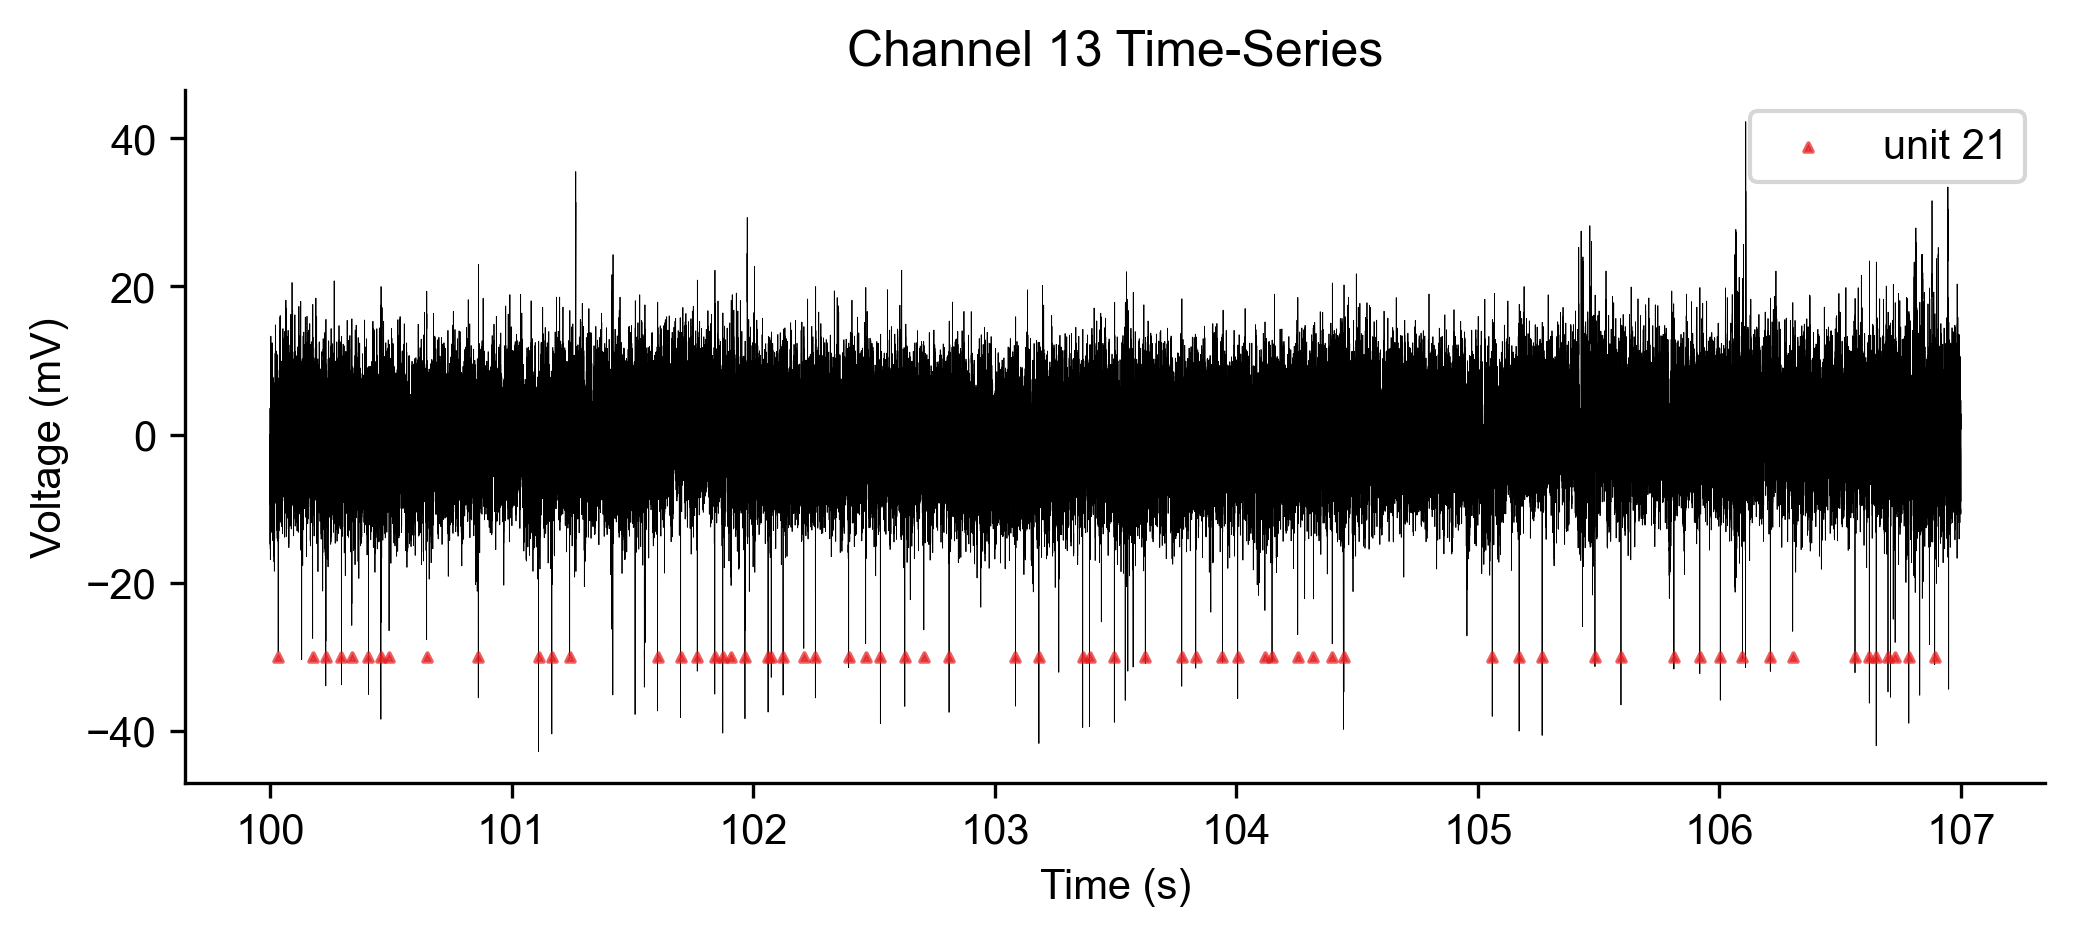

In [11]:
channel_signals["ch13"].plot_signal()

As we can see, the spikes of the unit are clearly visible on the channel, but there is a lot of background activity. The following is a channel with a high spiking SNR for the unit.

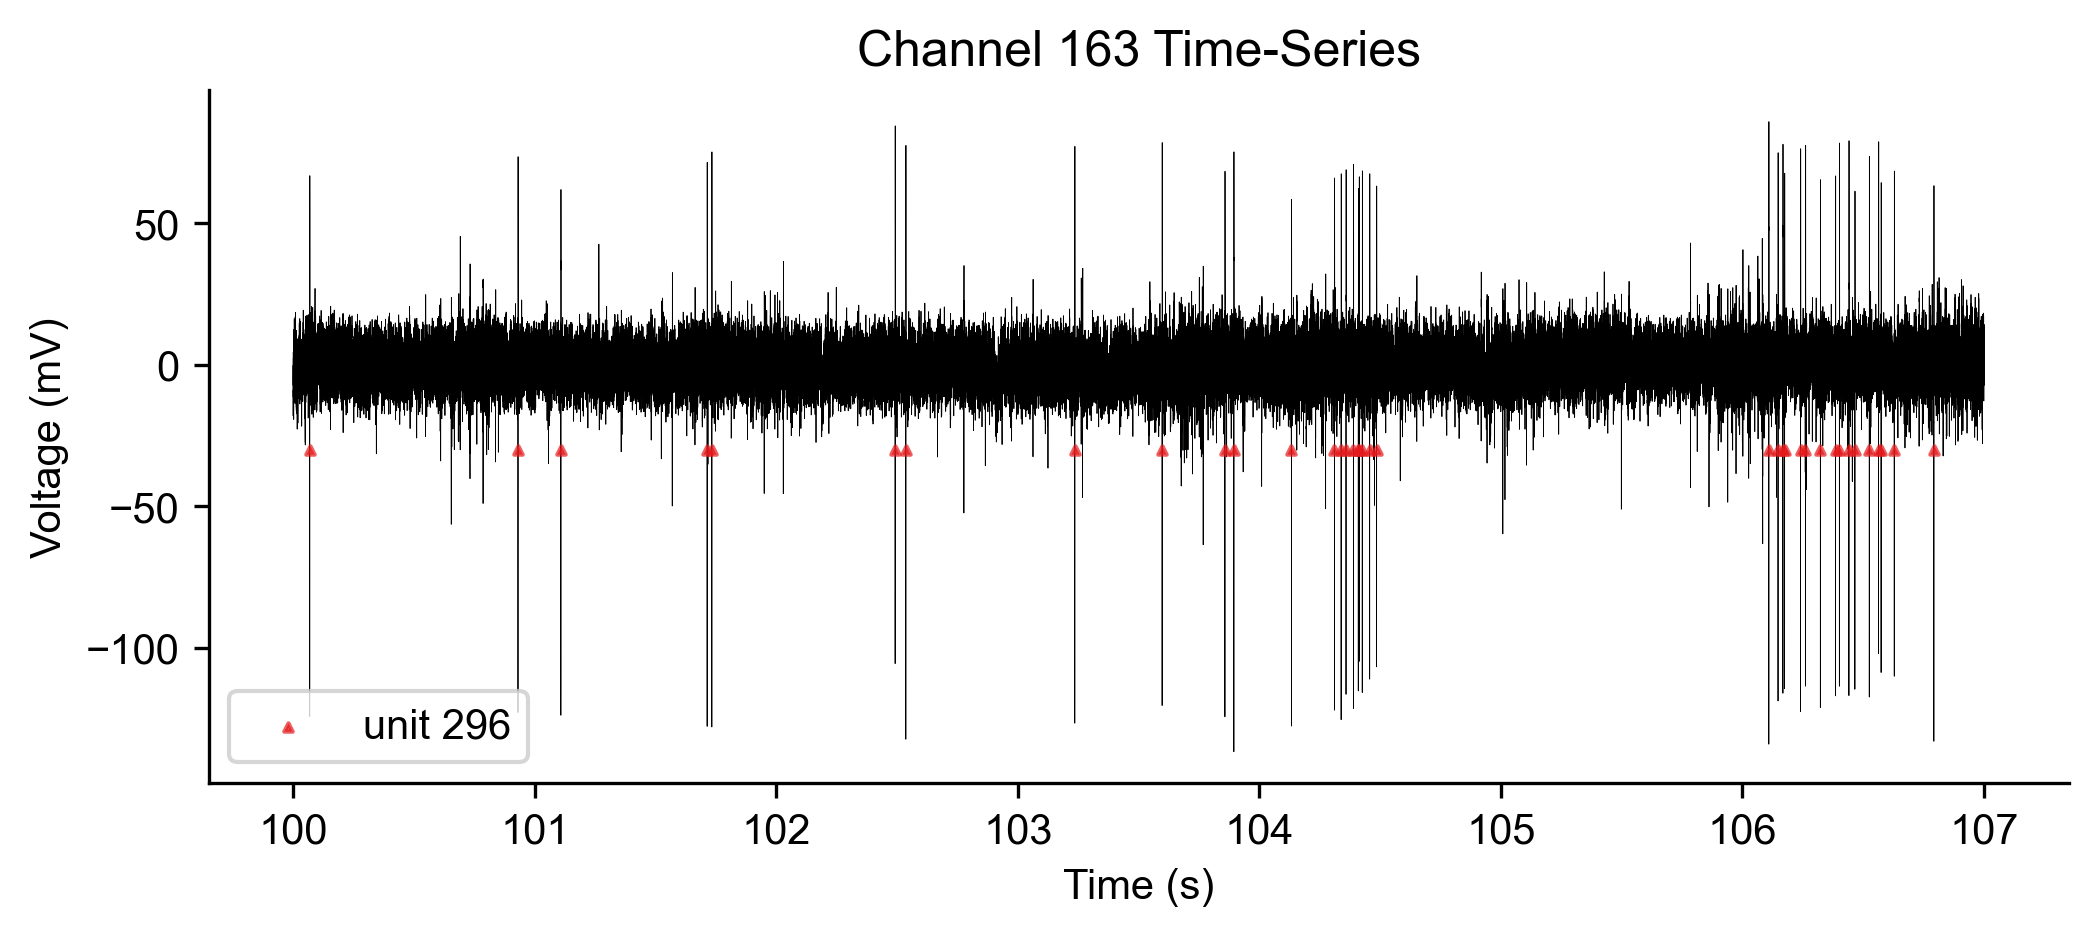

In [12]:
channel_signals['ch163'].plot_signal()

Lastly, here is a channel with the spikes of many units visible on the time-series. There are even other units mainly detected on other channels that are visible on the trace.

In [13]:
# additional units from other channels found on the time-series
add_spikes = [
    channel_signals['ch205'].spike_times[374],
    channel_signals['ch205'].spike_times[375]
]

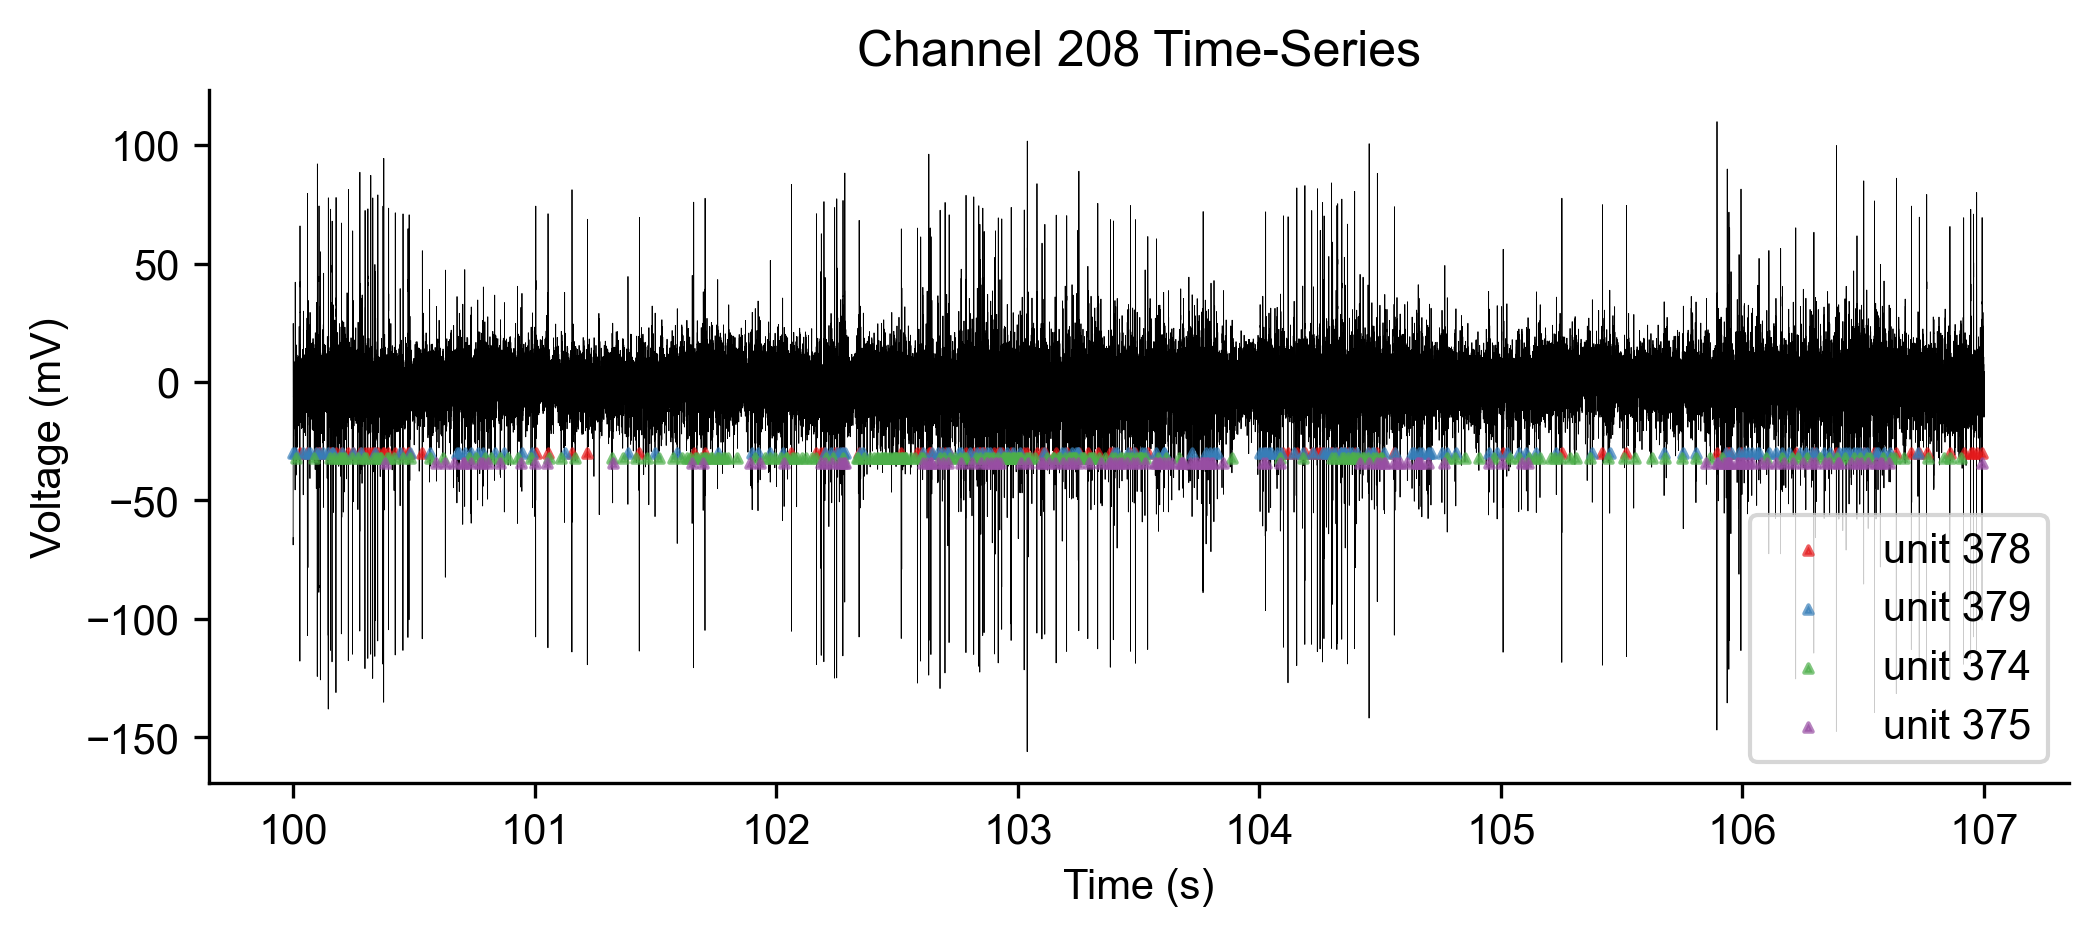

In [14]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375])

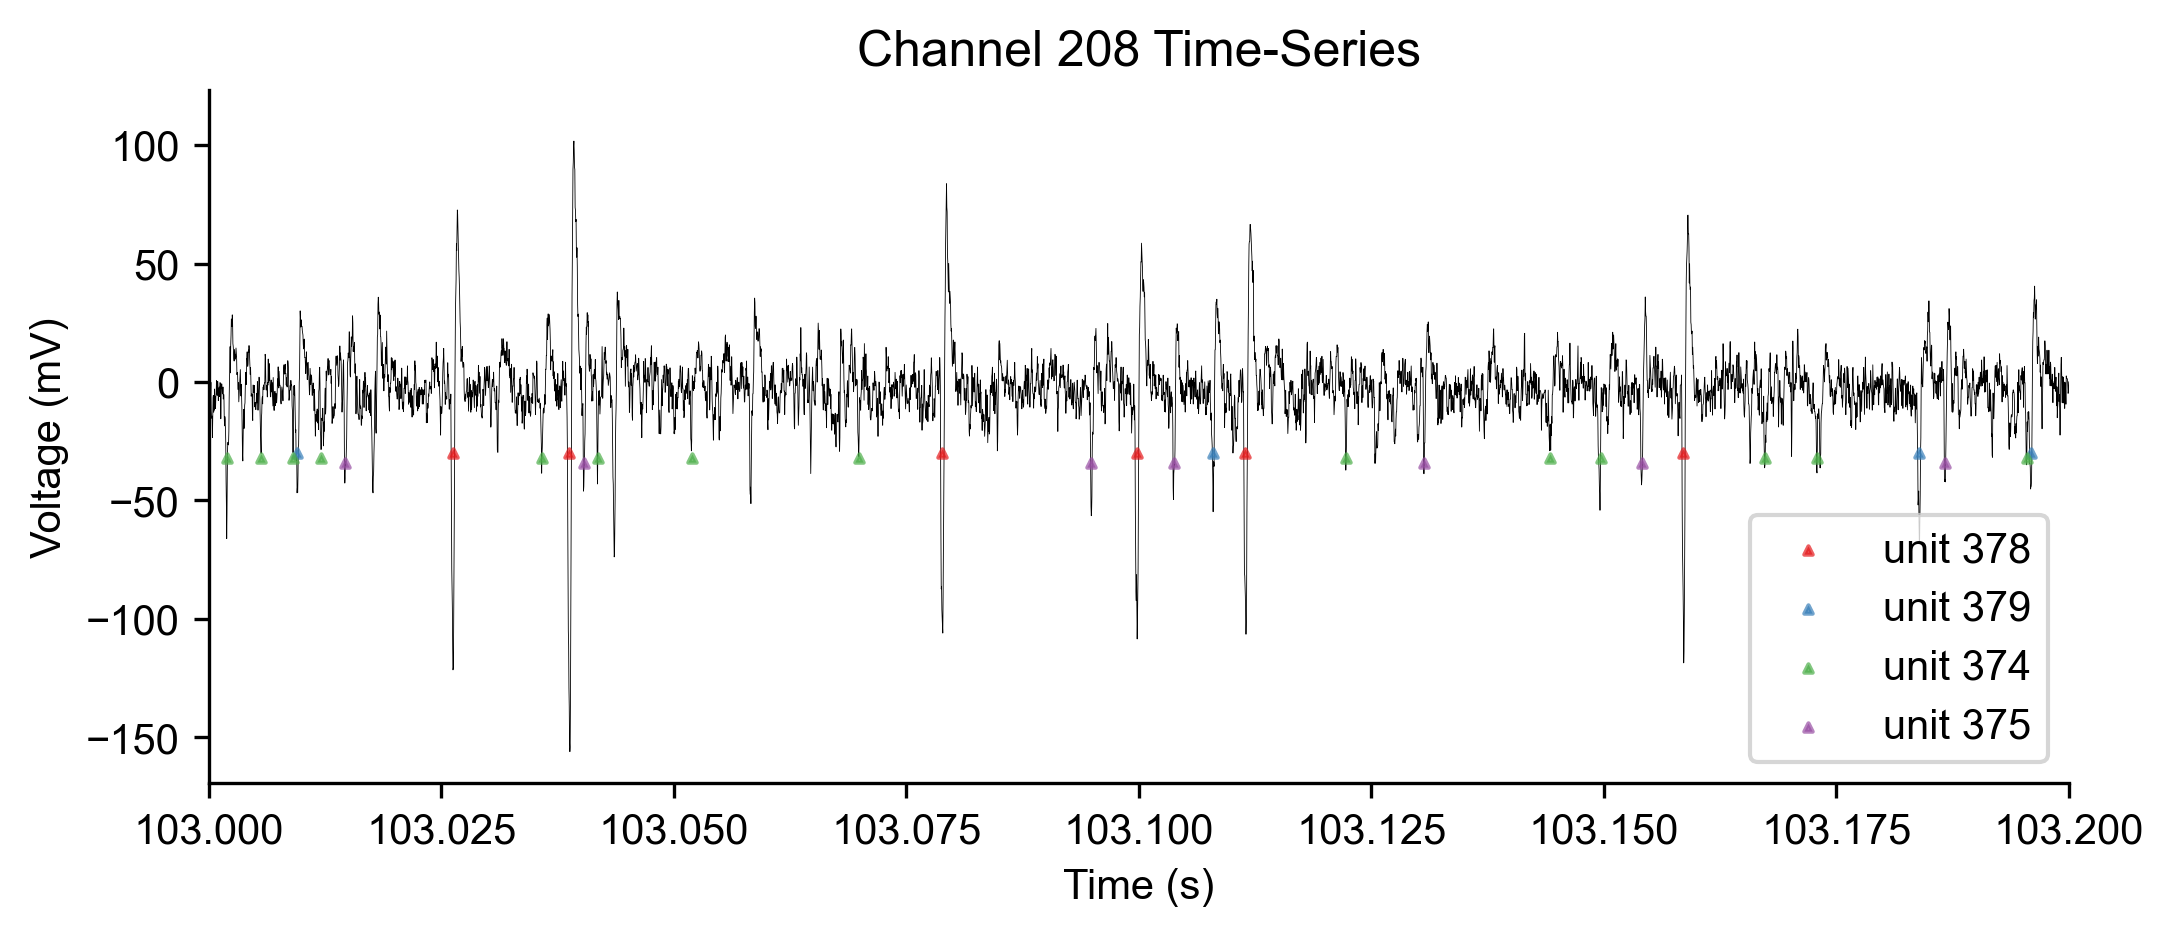

In [15]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375], xlim=(103,103.2))

Zoomed in, we can clearly see consistent spiking of the 4 units located on both channels 208 and 205 as well as other units not labeled.

### Channel spectra

Since we are quantifying the effects of neuronal processes on the spectra, we will plot the spectra. We will compute the multitapered spectra of the signals.

In [ ]:
ch13_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch13'].time_series, fs, 7)
ch163_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch163'].time_series, fs, 7)
ch208_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch208'].time_series, fs, 7)

We will also smooth the multitapered spectra with a Savitzky-Golay filter for the sake of future visualizations.

In [ ]:
# applies two scipy savgol filters to two parts of the spectrum
ch13_PSD_smooth = fn.spectrafuncs.spectrum_smooth2(ch13_PSD, mt_freqs, [10, 100, 1000, 500], [30, 100, 500], 4)
ch163_PSD_smooth = fn.spectrafuncs.spectrum_smooth(ch163_PSD, mt_freqs, 50, 1000, 100, 4)
ch208_PSD_smooth = fn.spectrafuncs.spectrum_smooth(ch208_PSD, mt_freqs, 100, 1000, 100, 4)

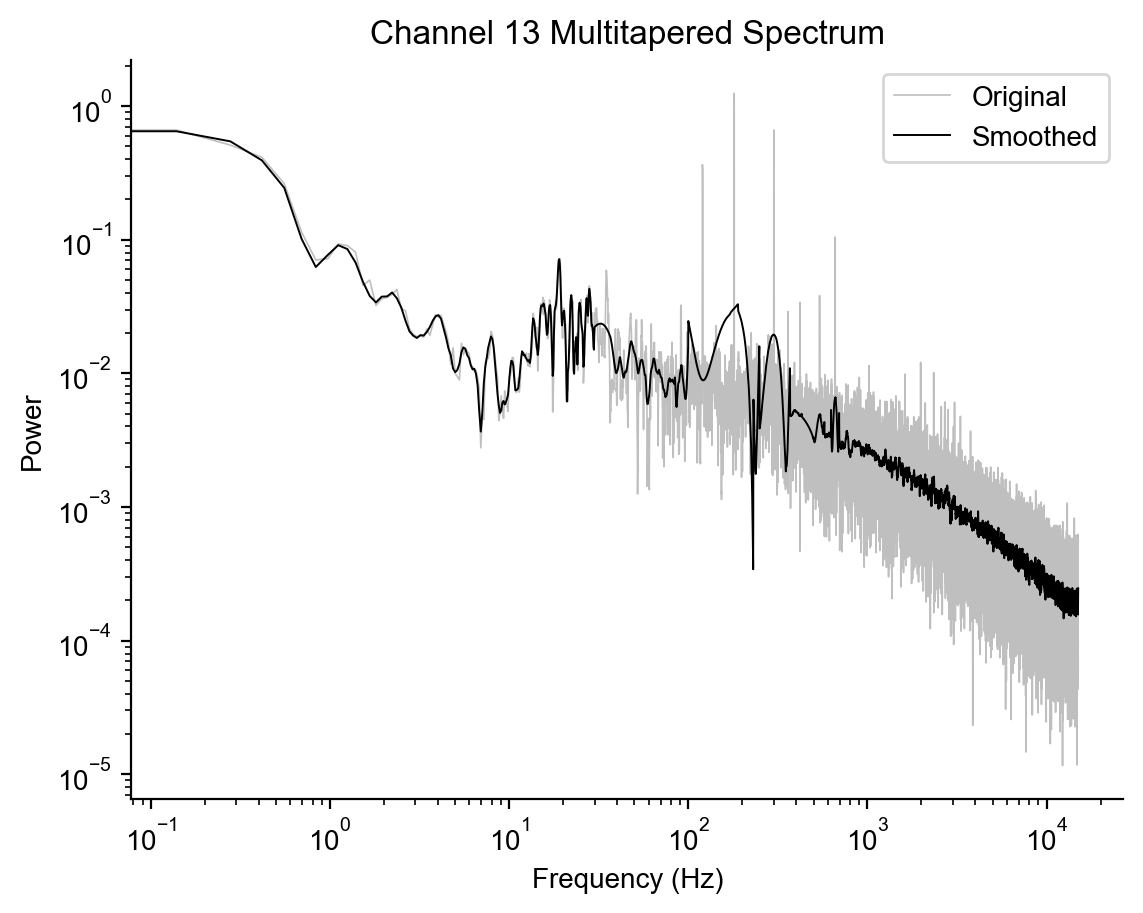

In [148]:
plt.figure(dpi=200)
plt.loglog(mt_freqs, ch13_PSD, alpha=0.5, color='gray', linewidth=0.6, label='Original')
plt.loglog(mt_freqs, ch13_PSD_smooth, color='k', linewidth=0.7, label='Smoothed')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 13 Multitapered Spectrum")
plt.legend()
plt.show()

The line noise harmonics on channel 13 are interfering with the filter.

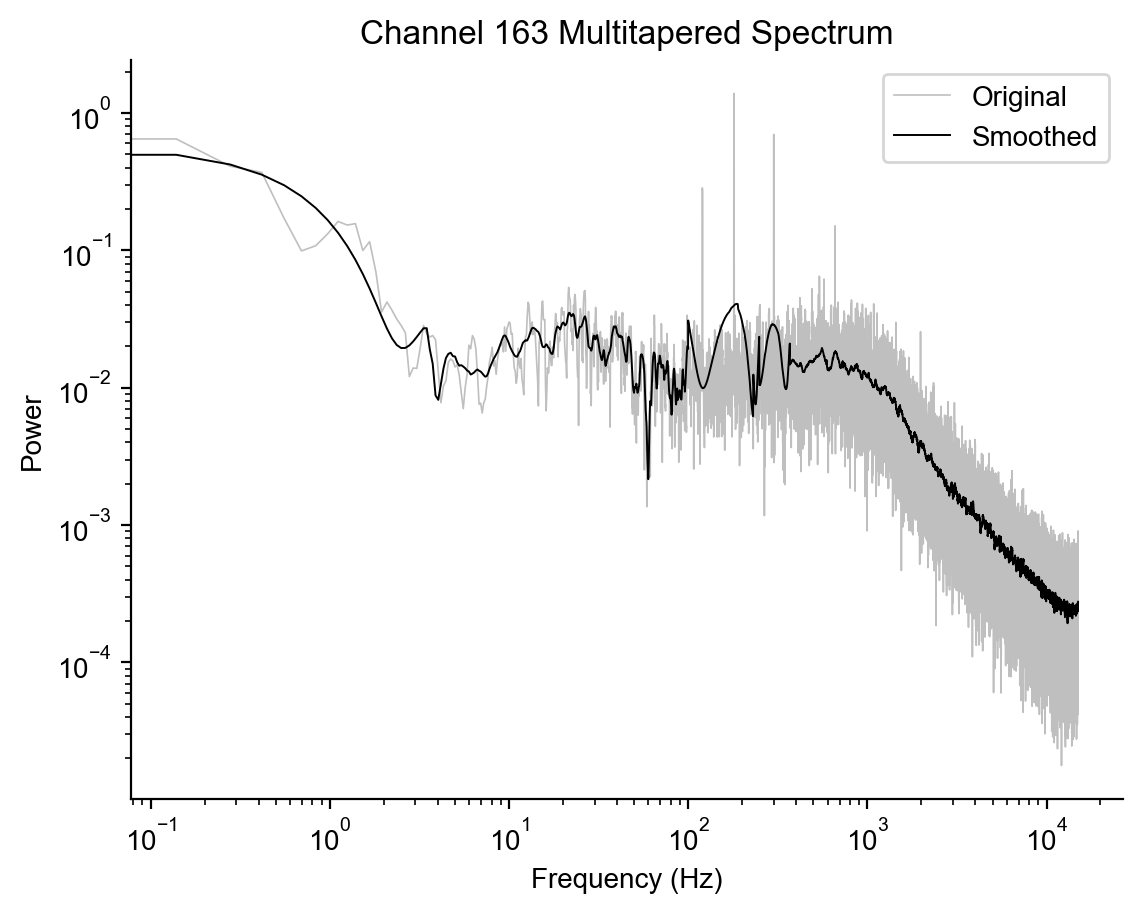

In [151]:
plt.figure(dpi=200)
plt.loglog(mt_freqs, ch163_PSD, alpha=0.5, color='gray', linewidth=0.6, label='Original')
plt.loglog(mt_freqs, ch163_PSD_smooth, color='k', linewidth=0.7, label='Smoothed')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 163 Multitapered Spectrum")
plt.legend()
plt.show()

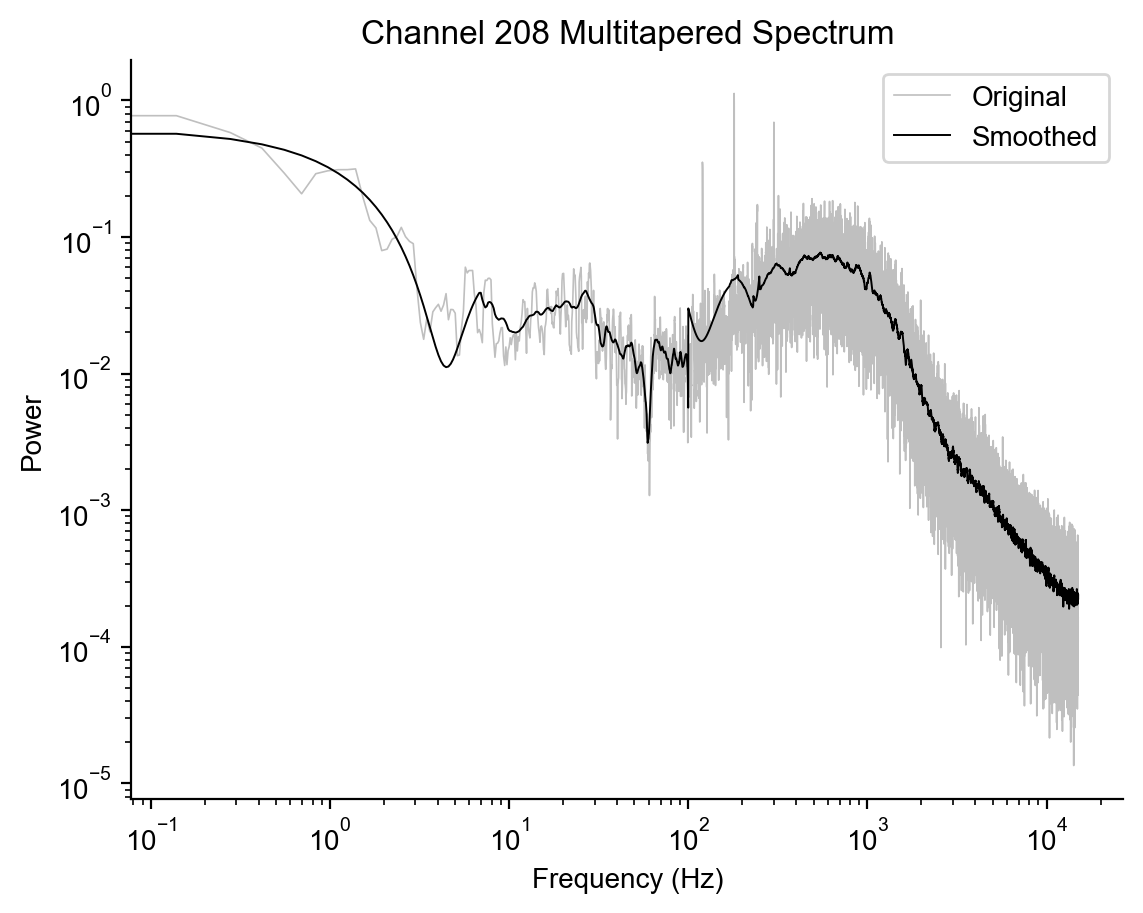

In [149]:
plt.figure(dpi=200)
plt.loglog(mt_freqs, ch208_PSD, alpha=0.5, color='gray', linewidth=0.6, label='Original')
plt.loglog(mt_freqs, ch208_PSD_smooth, color='k', linewidth=0.7, label='Smoothed')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 208 Multitapered Spectrum")
plt.legend()
plt.show()

### Spike waveforms

We will be looking at the contributions of spikes to the spectra, therefore we will calculate and plot the time domain, frequency domain, and power spectral density of the spike waveforms.

In [169]:
u21_instances,u21_filters,theor_freqs = channel_signals['ch13'].generate_unit_filters(selected_unit=21, truncate_idx=58)
u296_instances,u296_filters,_ = channel_signals['ch163'].generate_unit_filters(selected_unit=296, truncate_idx=74)
u378_instances,u378_filters,_ = channel_signals['ch208'].generate_unit_filters(selected_unit=378)
u379_instances,u379_filters,_ = channel_signals['ch208'].generate_unit_filters(selected_unit=379)
u374_instances,u374_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=374)
u375_instances,u375_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=375)

Unit 21 Filters:

c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


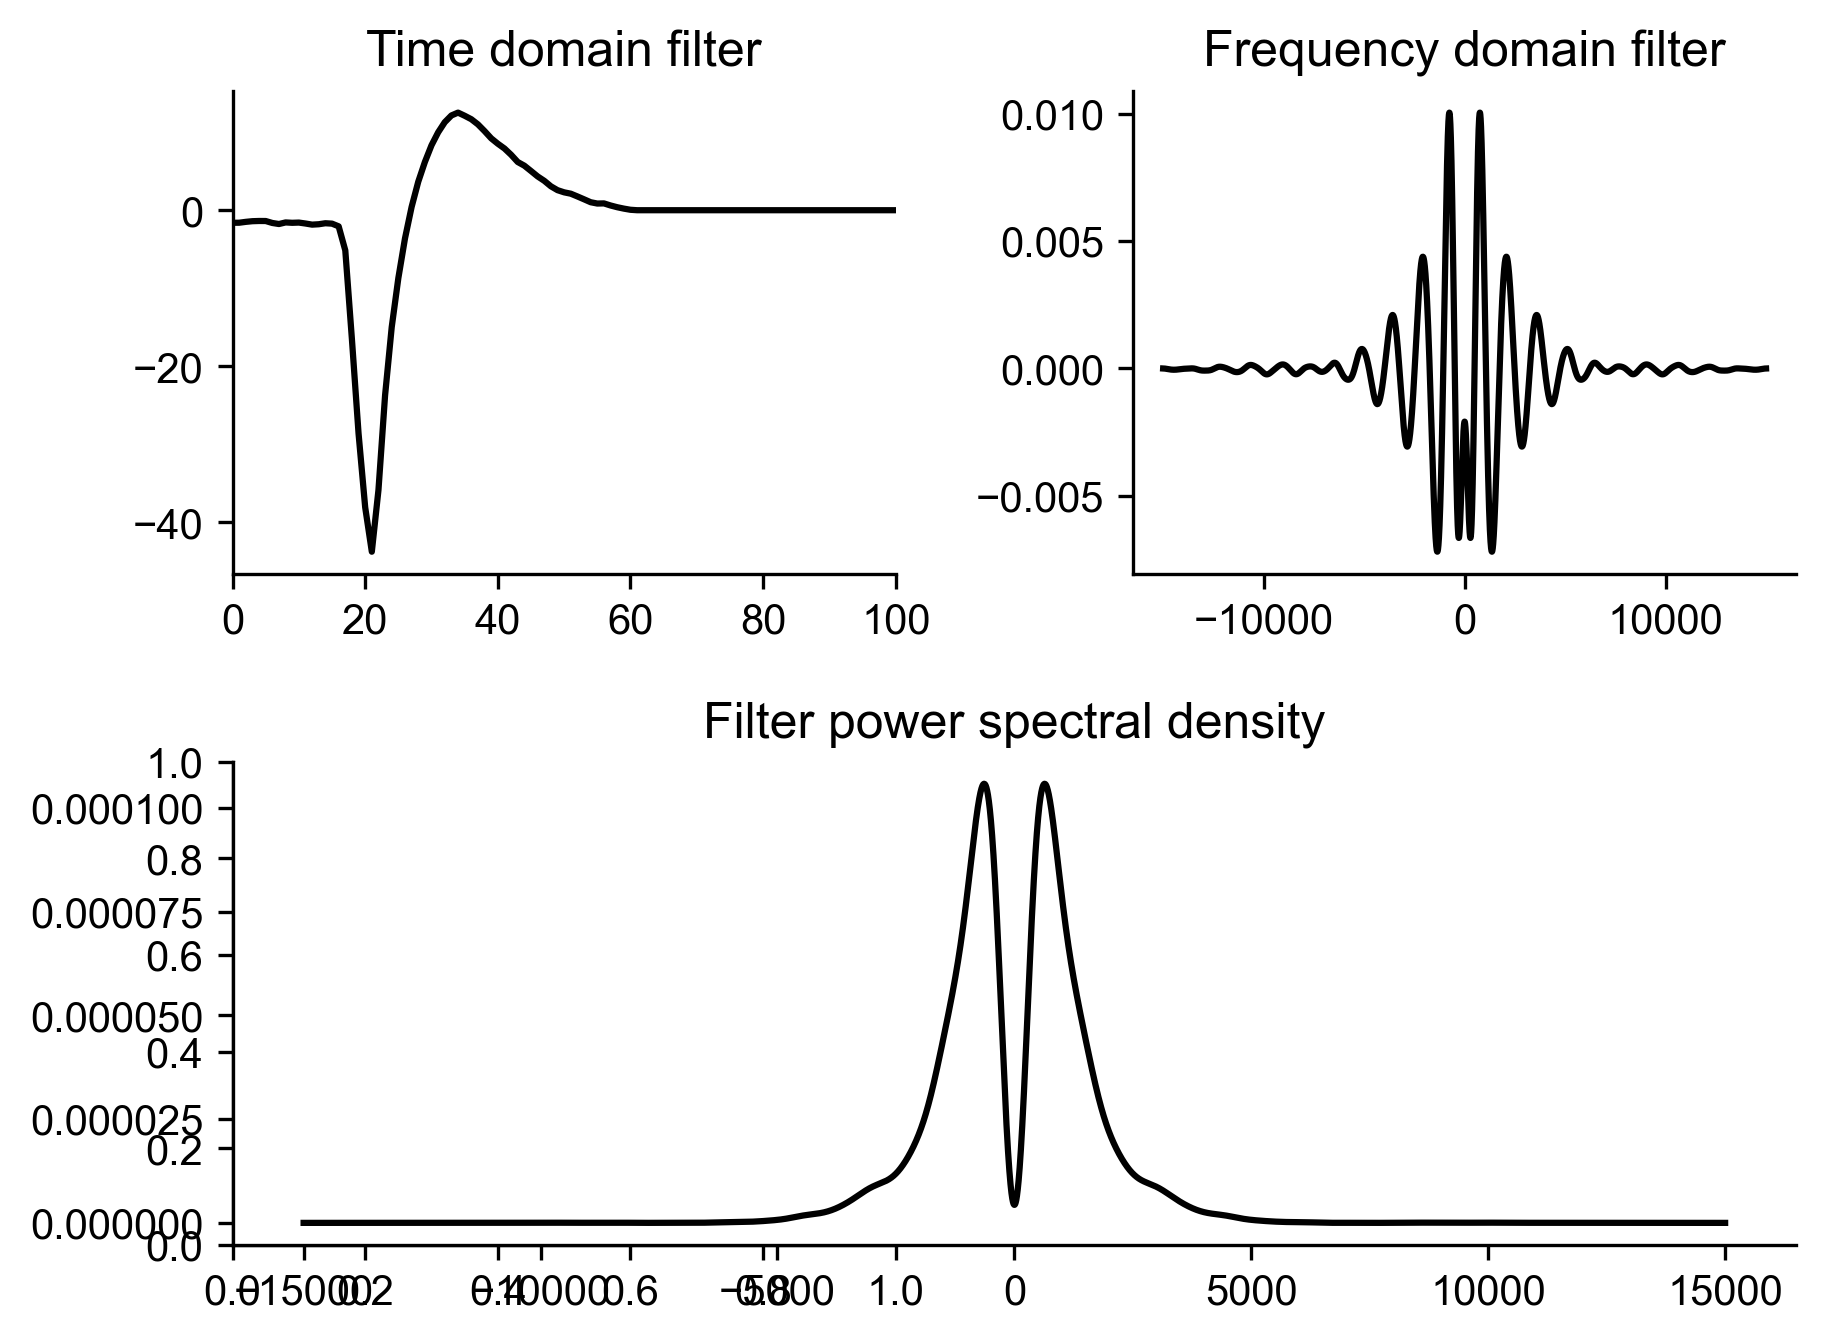

In [241]:
fn.filterfuncs.plot_filters(u21_filters['average_waveform']['time_filter'],
                            u21_filters['average_waveform']['freq_filter'],
                            u21_filters['average_waveform']['filter_psd'], theor_freqs)

Unit 296 filters:

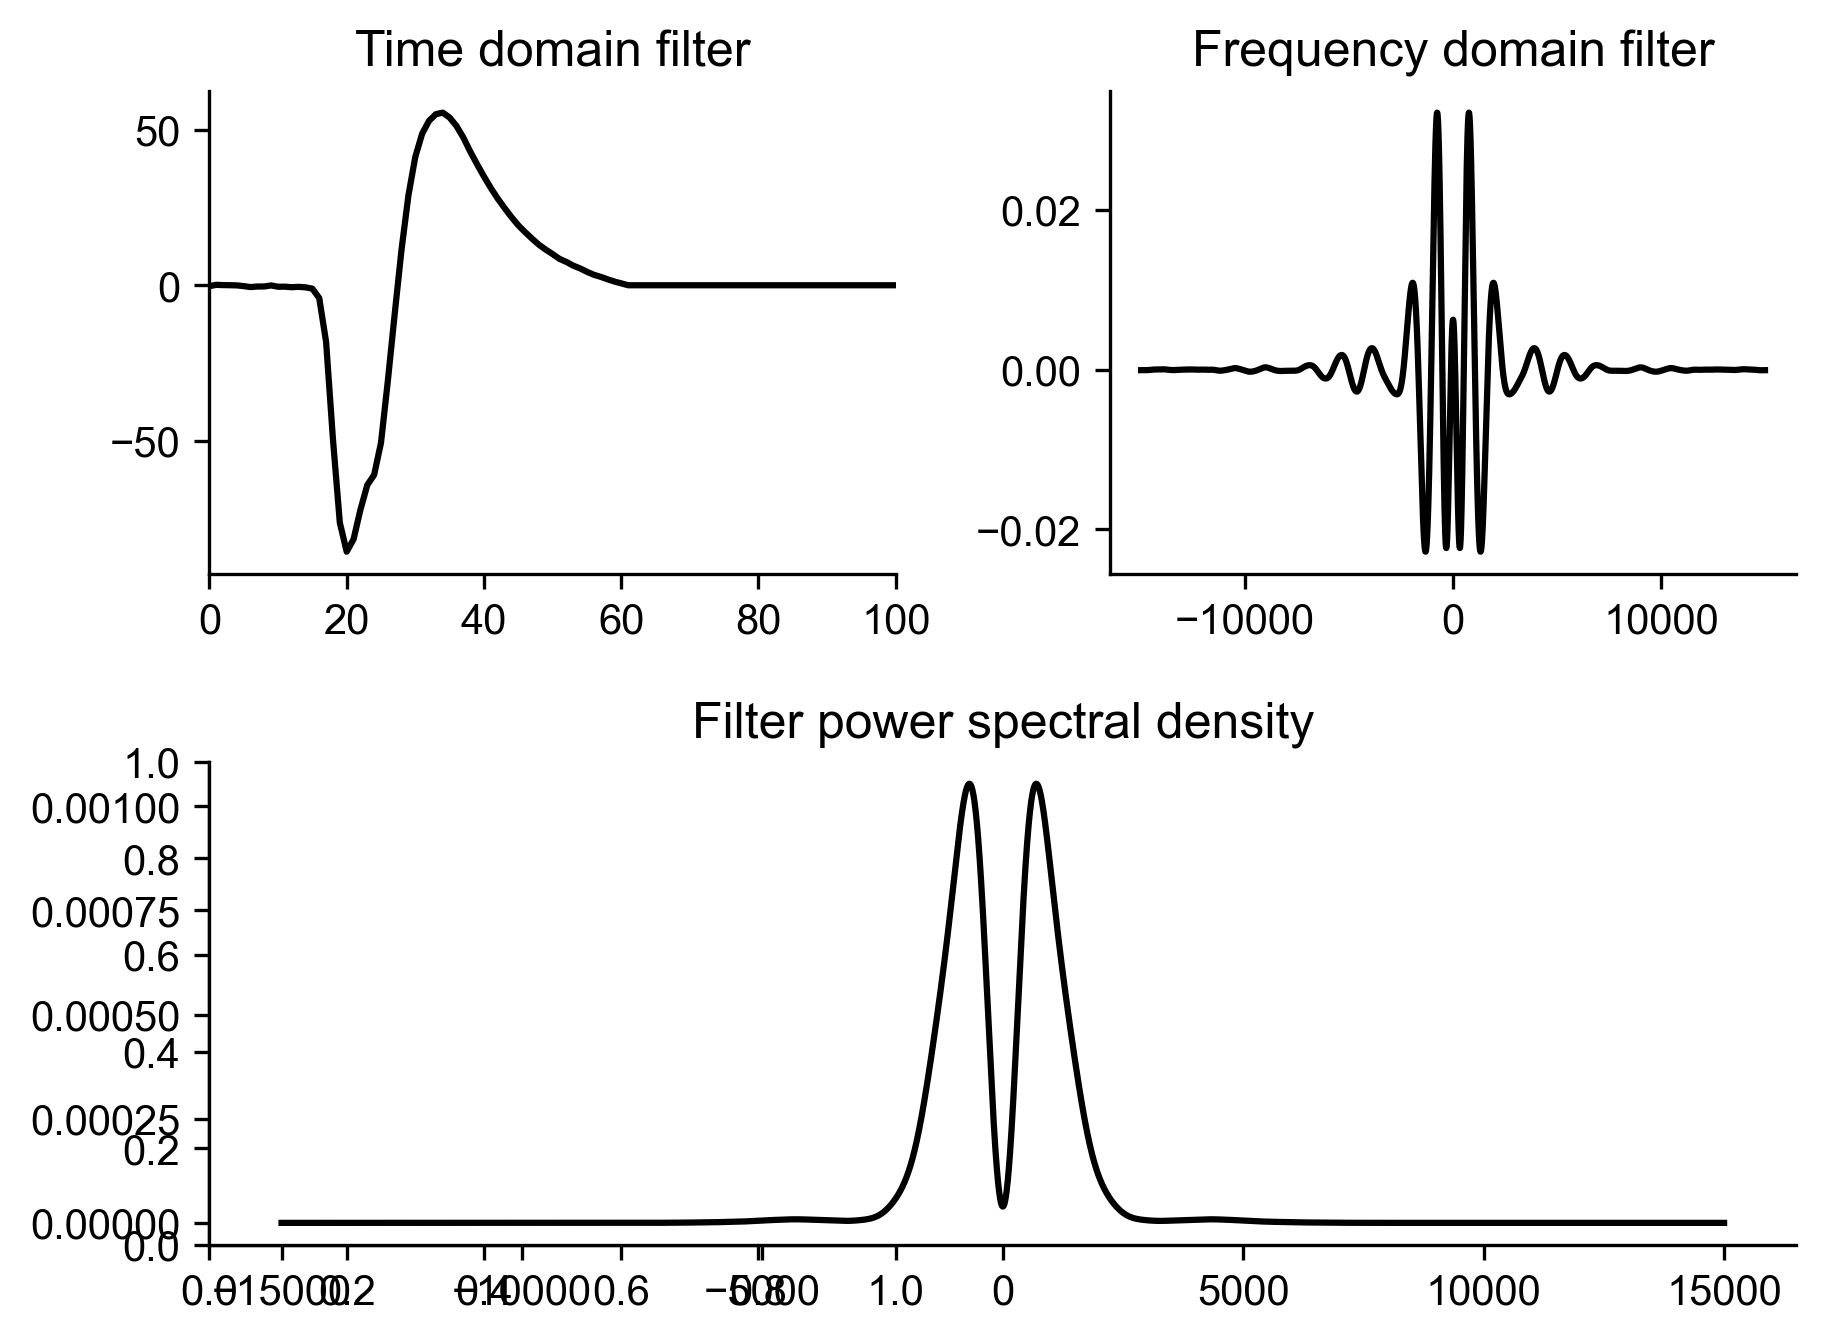

In [242]:
fn.filterfuncs.plot_filters(u296_filters['average_waveform']['time_filter'],
                            u296_filters['average_waveform']['freq_filter'],
                            u296_filters['average_waveform']['filter_psd'], theor_freqs)

Unit 379 filters:

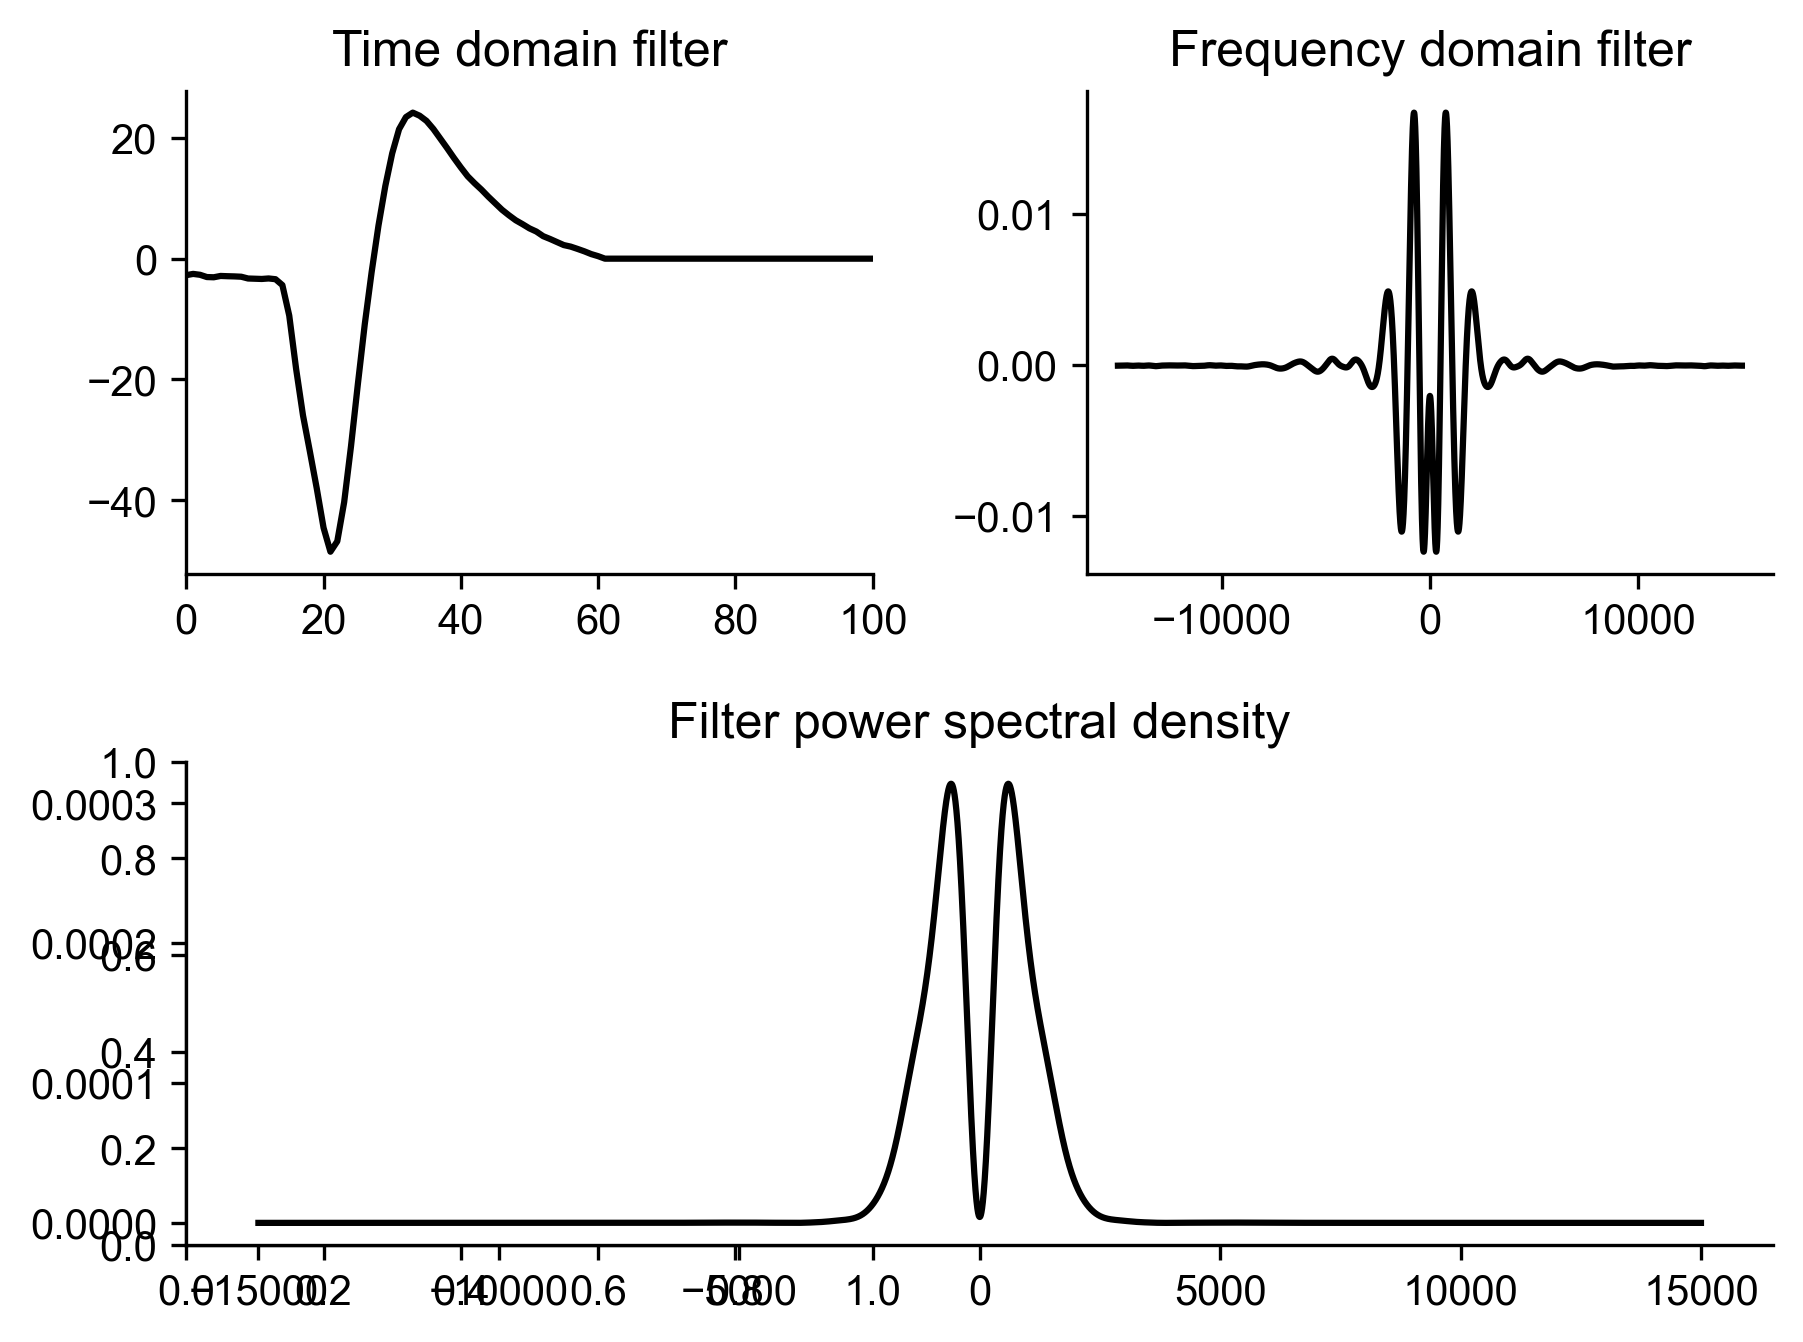

In [243]:
fn.filterfuncs.plot_filters(u379_filters['average_waveform']['time_filter'],
                            u379_filters['average_waveform']['freq_filter'],
                            u379_filters['average_waveform']['filter_psd'], theor_freqs)

We should also look at what kind of averaging to use when obtaining the filters we will work with. We can use the average waveform from the entire recording (waveform-averaged) or we can use the average waveform from the instances within the signal excerpt (the 100-107 seconds, instance-averaged). We can compute the PSD for the waveform-averaged filter, compute the PSD for the instance-averaged filter, or compute the PSD of each instance within the signal excerpt and average afterwards. 

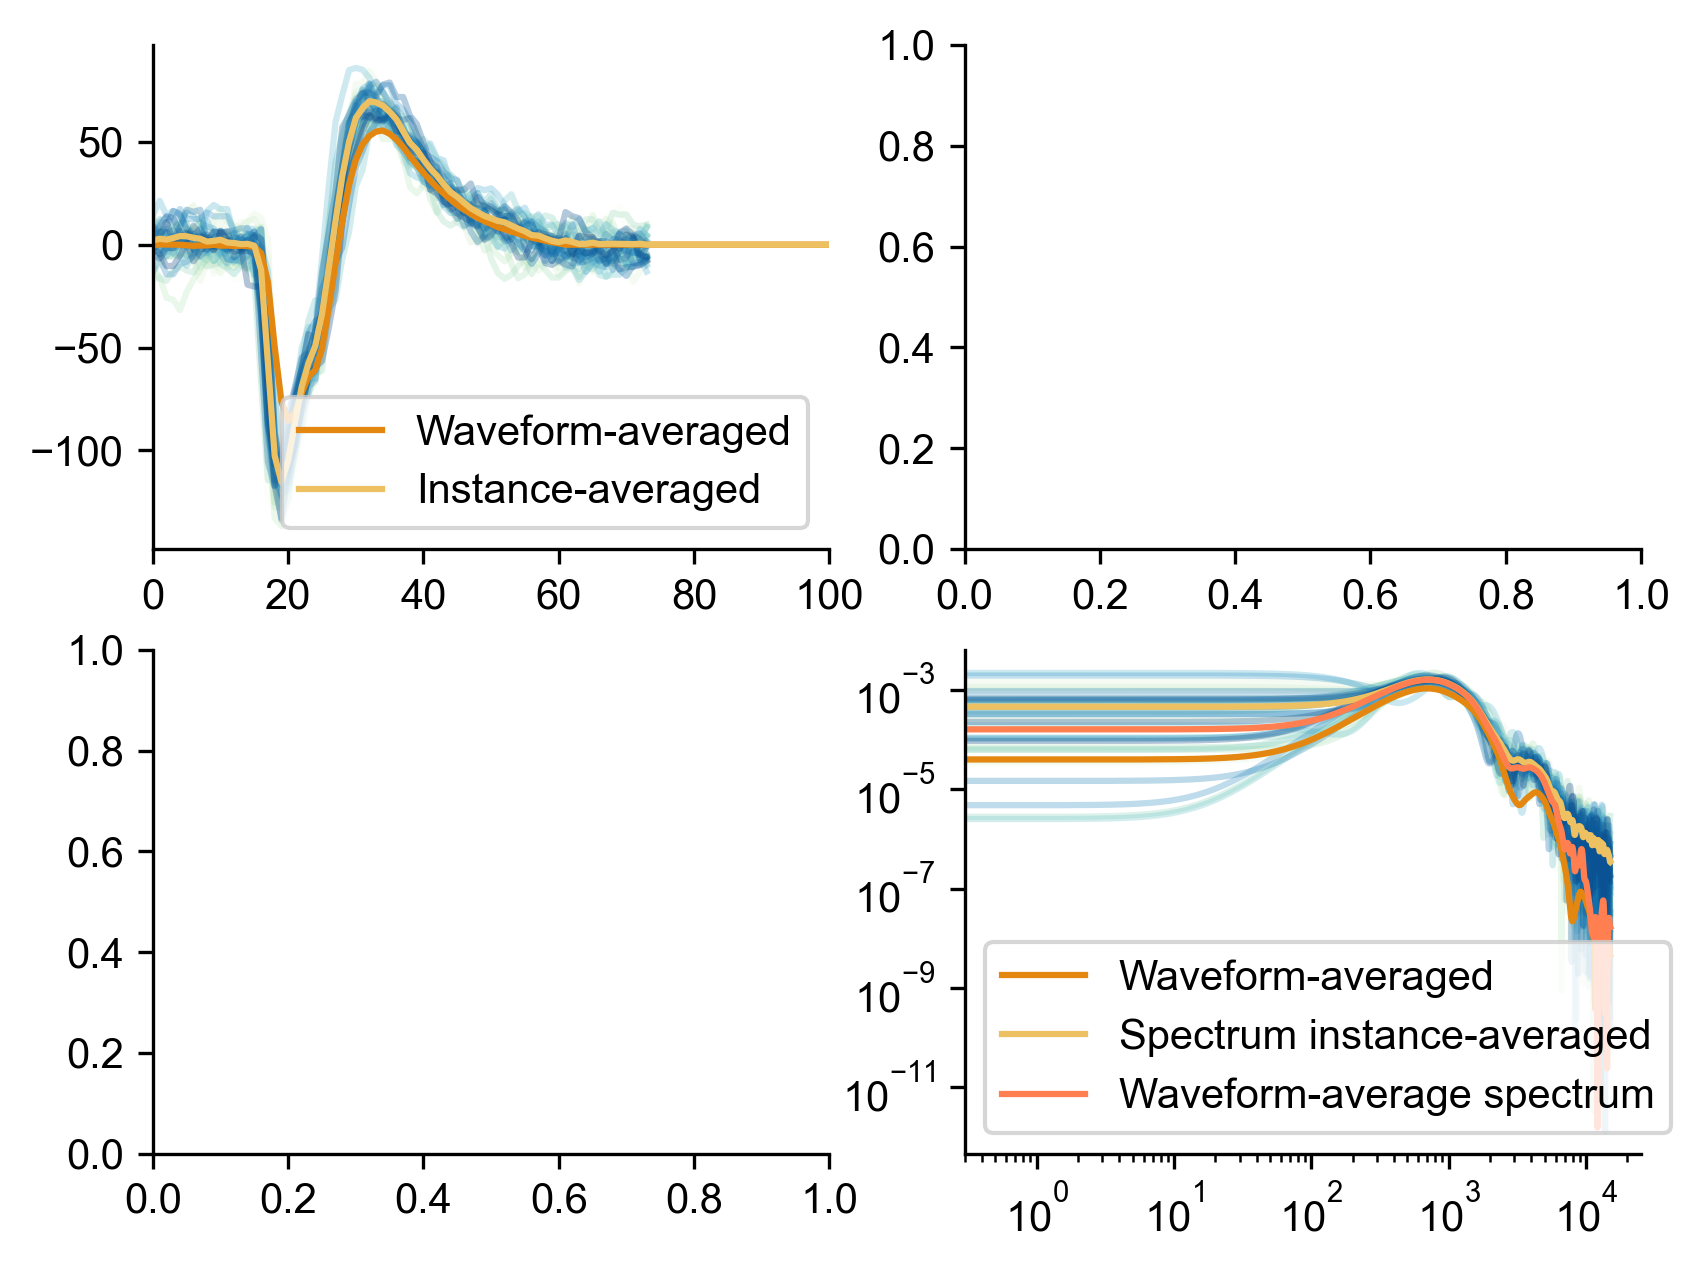

In [218]:
fn.filterfuncs.plot_ia_filters(u296_instances, u296_filters,theor_freqs)

### Waveform analysis

We eventually want to find if cell types with distinct waveforms have different contributions to the channel signal power spectrum. Therefore, we shall use WaveMAP, a nonlinear dimensionality reduction method for detecting waveform clusters, to distinguish putative cell types.

In [ ]:
# takes the average waveform from each unit
mean_unit_waveforms = np.array(signal_dataset["waveform_info"]["waveforms"]).mean(axis=2)
mean_unit_waveforms.shape

(138, 62)

These are the average waveforms for each unit:

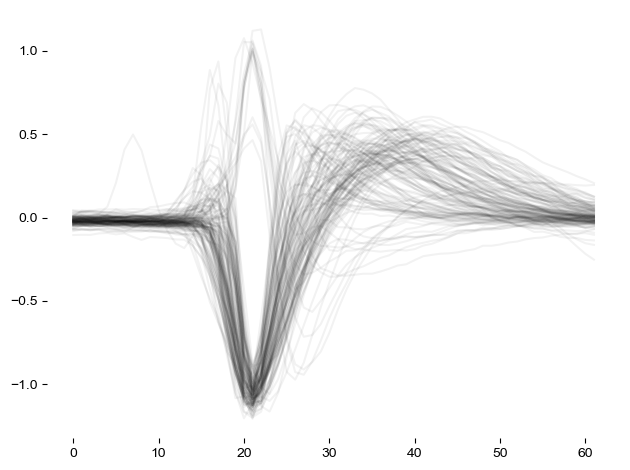

In [177]:
wmc = WaveMAPClassifier(mean_unit_waveforms)
wmc.plot_waveforms()

In [178]:
wmc.compute_waveform_umap()
wmc.apply_louvain_method()

Computing UMAP: 15 neighbors | 0.1 minimum distance | random state 42


c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP computed!
Applying Louvain method: 1.5 resolution
9 clusters detected.


c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\Mateo\Documents\BU\fppnpx\fpp-npx\wavemapnpx\WaveMAPClassifier.py:184: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


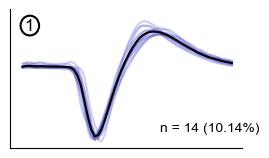

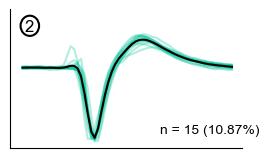

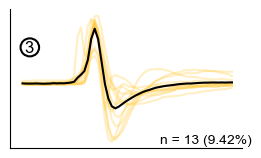

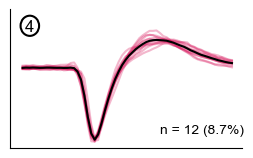

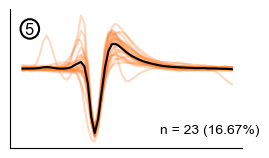

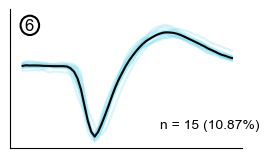

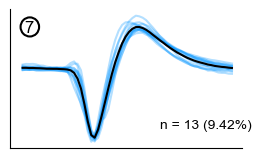

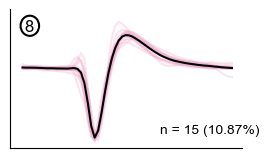

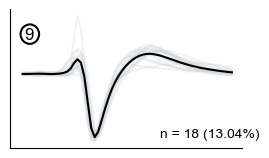

In [179]:
wmc.plot_groups()

In [ ]:
wavemap_cluster_labels = np.array(wmc.clustering_solution)
np.save("chkdelay_dlpfc_0630_wavemap_clusters_0327", wavemap_cluster_labels) # TO-DO: dynamically name saved labels

We can superimpose the waveforms and their spectra to visualize how distinguishable they are.

In [197]:
def extract_mean_kernels(labels, groups_df, n, fs):
    time_kernel_means = []
    frequency_kernel_means = []
    kernel_psd_means = []
    kernel_psd_ATKs = []

    for label_ix in range(1, 9+1):
        group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
        group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()

        time_kernels = []
        frequency_kernels = []
        kernel_psds = []    
        kernel_psds_ATK = []

        for waveform in group_waveforms:
            kernel_t,kernel_f,kernel_psd,freq_axis = fn.filterfuncs.gen_filter(waveform, n, fs, center=True)
            time_kernels.append(kernel_t)
            frequency_kernels.append(kernel_f)
            kernel_psds.append(kernel_psd)
        
        time_kernel_mean = np.array(time_kernels).mean(axis=0)
        freq_kernel_mean = np.array(frequency_kernels).mean(axis=0)
        kernel_psd_mean = np.array(kernel_psds).mean(axis=0)

        _, __,kernel_psd_ATK,___ = fn.filterfuncs.gen_filter(time_kernel_mean, n, fs, center=True)
        
        time_kernel_means.append(time_kernel_mean)
        frequency_kernel_means.append(freq_kernel_mean)
        kernel_psd_means.append(kernel_psd_mean)
        kernel_psd_ATKs.append(kernel_psd_ATK)

    mean_kernels = {
        "time_kernels":np.array(time_kernel_means),
        "freq_kernels": np.array(frequency_kernel_means),
        "kernel_psds": np.array(kernel_psd_means),
        "kernel_psds_ATK": np.array(kernel_psd_ATKs)
    }

    return mean_kernels, freq_axis

In [198]:
wavemap_kernels, wm_freq_axis = extract_mean_kernels(wavemap_cluster_labels, wmc.umap_df, fs, fs)

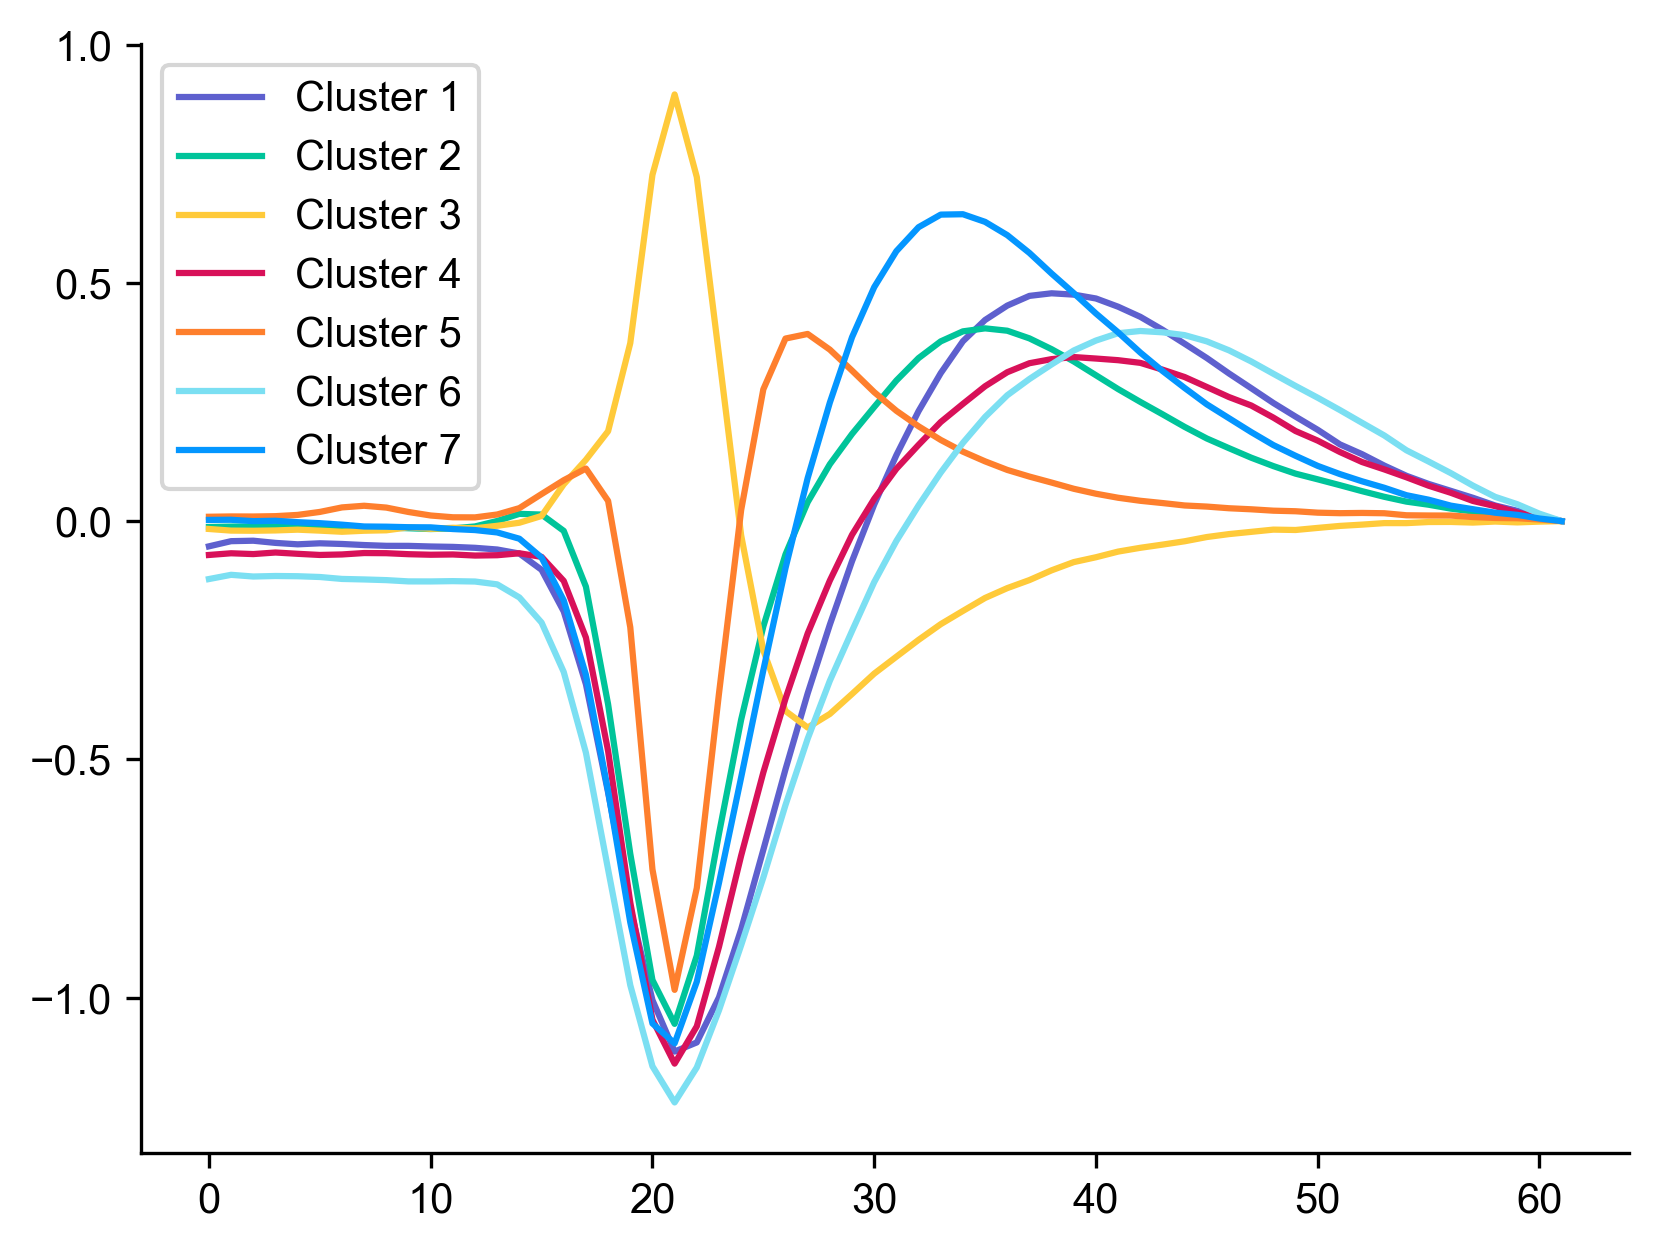

In [199]:
plt.figure(dpi=300)
for i in range(7):
    plt.plot(wavemap_kernels['time_kernels'][i,:62], color=CUSTOM_PAL_SORT_3[i], label=f'Cluster {i+1}')
plt.legend()
plt.show()

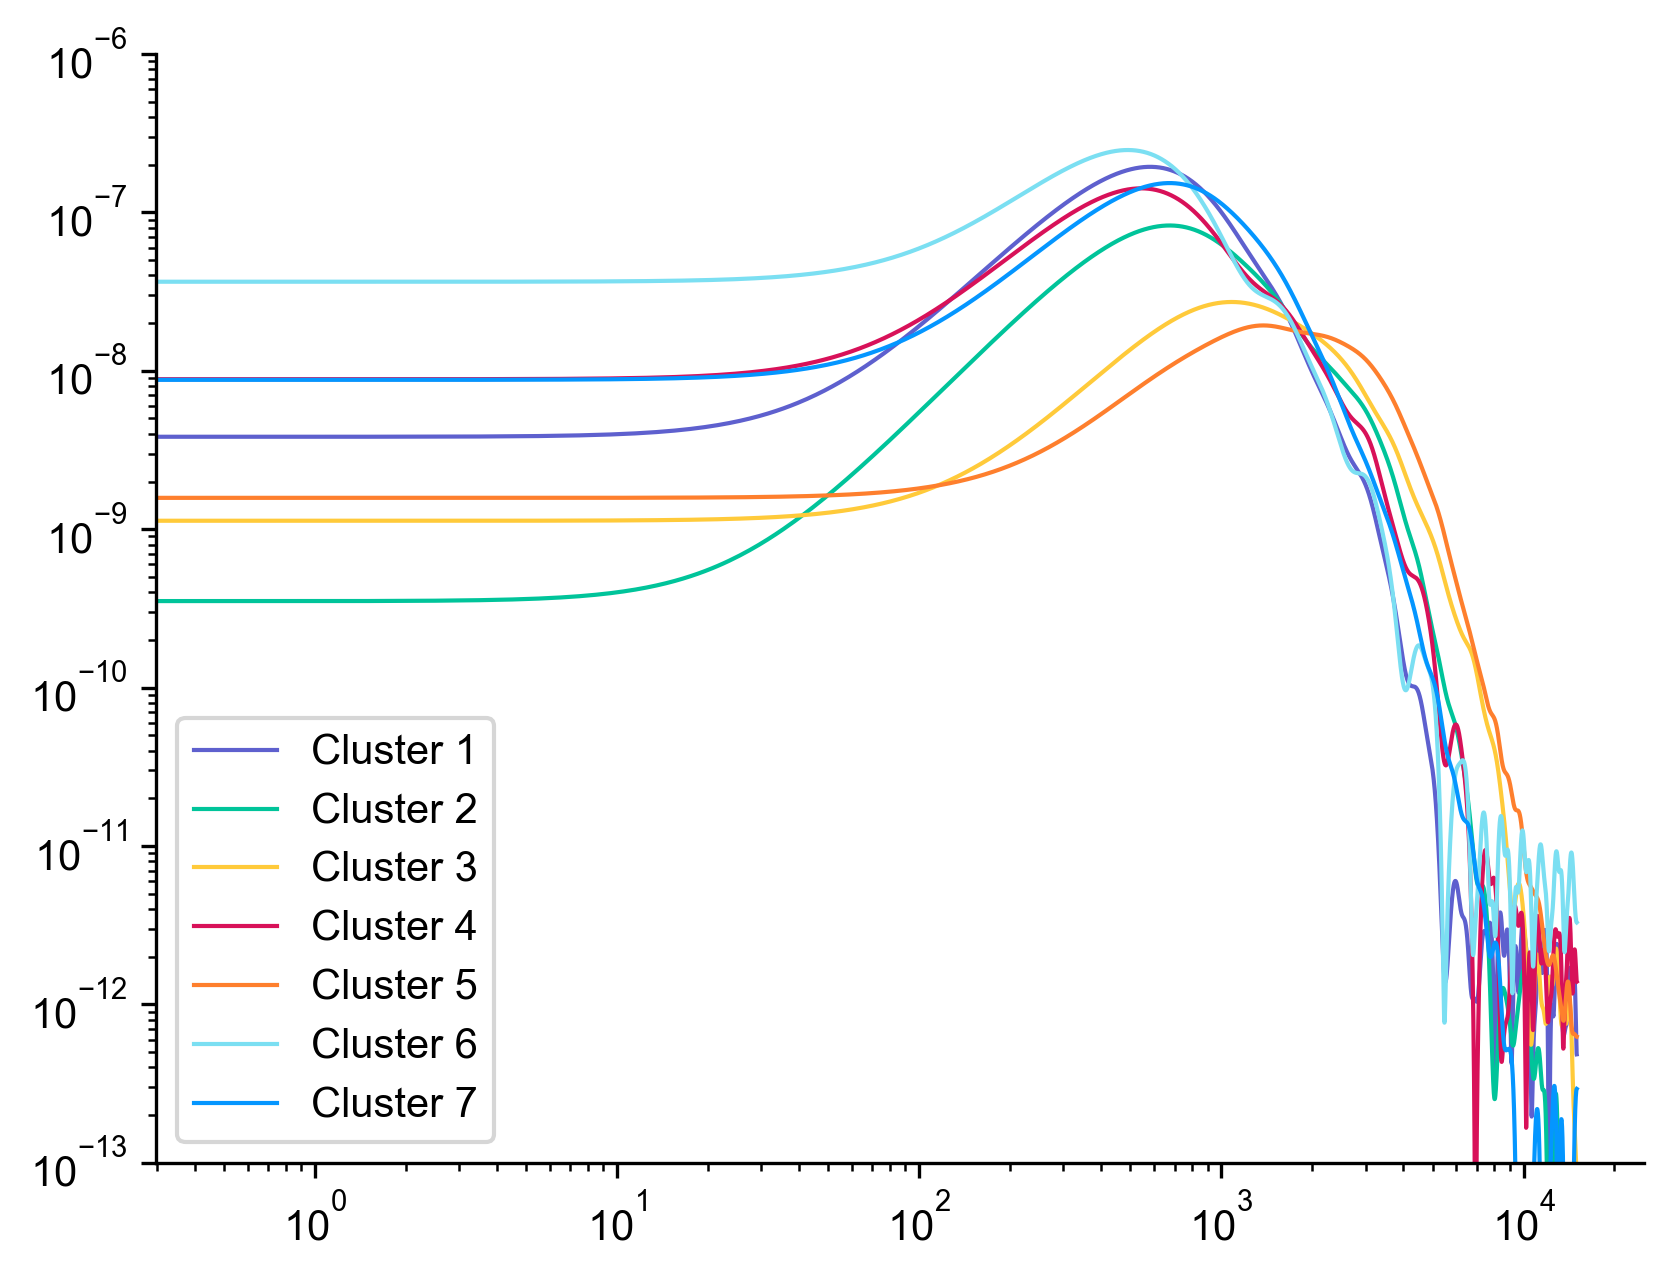

In [201]:
plt.figure(dpi=300)

for clust_idx in range(7):
    plt.loglog(wm_freq_axis, wavemap_kernels['kernel_psds_ATK'][clust_idx], linewidth=1, label=f"Cluster {clust_idx+1}", color=CUSTOM_PAL_SORT_3[clust_idx])
plt.legend()
plt.ylim((1e-13,1e-6))
plt.show()

We want to see if firing rate for different cell types can be decoded from the power spectrum. Therefore, we can see if along the entire probe, different cell types have distinguishable firing rates.

In [ ]:

unit_firing_rates = {}

for chan in signal_dataset['channel_unit_index']:
    for u in signal_dataset['channel_unit_index'][chan]:
        unit_firing_rates[u] = channel_signals[f'ch{chan}'].firing_rates[u]

unit_wavemap_label_dict = {}
wavemap_cluster_FRs = []

for i in range(9):
    cluster_i_FRs = []
    for clust_unit in signal_dataset['units'][np.where(wavemap_cluster_labels == i)]:
        unit_wavemap_label_dict[clust_unit] = i
        if unit_firing_rates[clust_unit] > 0:
            cluster_i_FRs.append(unit_firing_rates[clust_unit])
    wavemap_cluster_FRs.append(cluster_i_FRs)

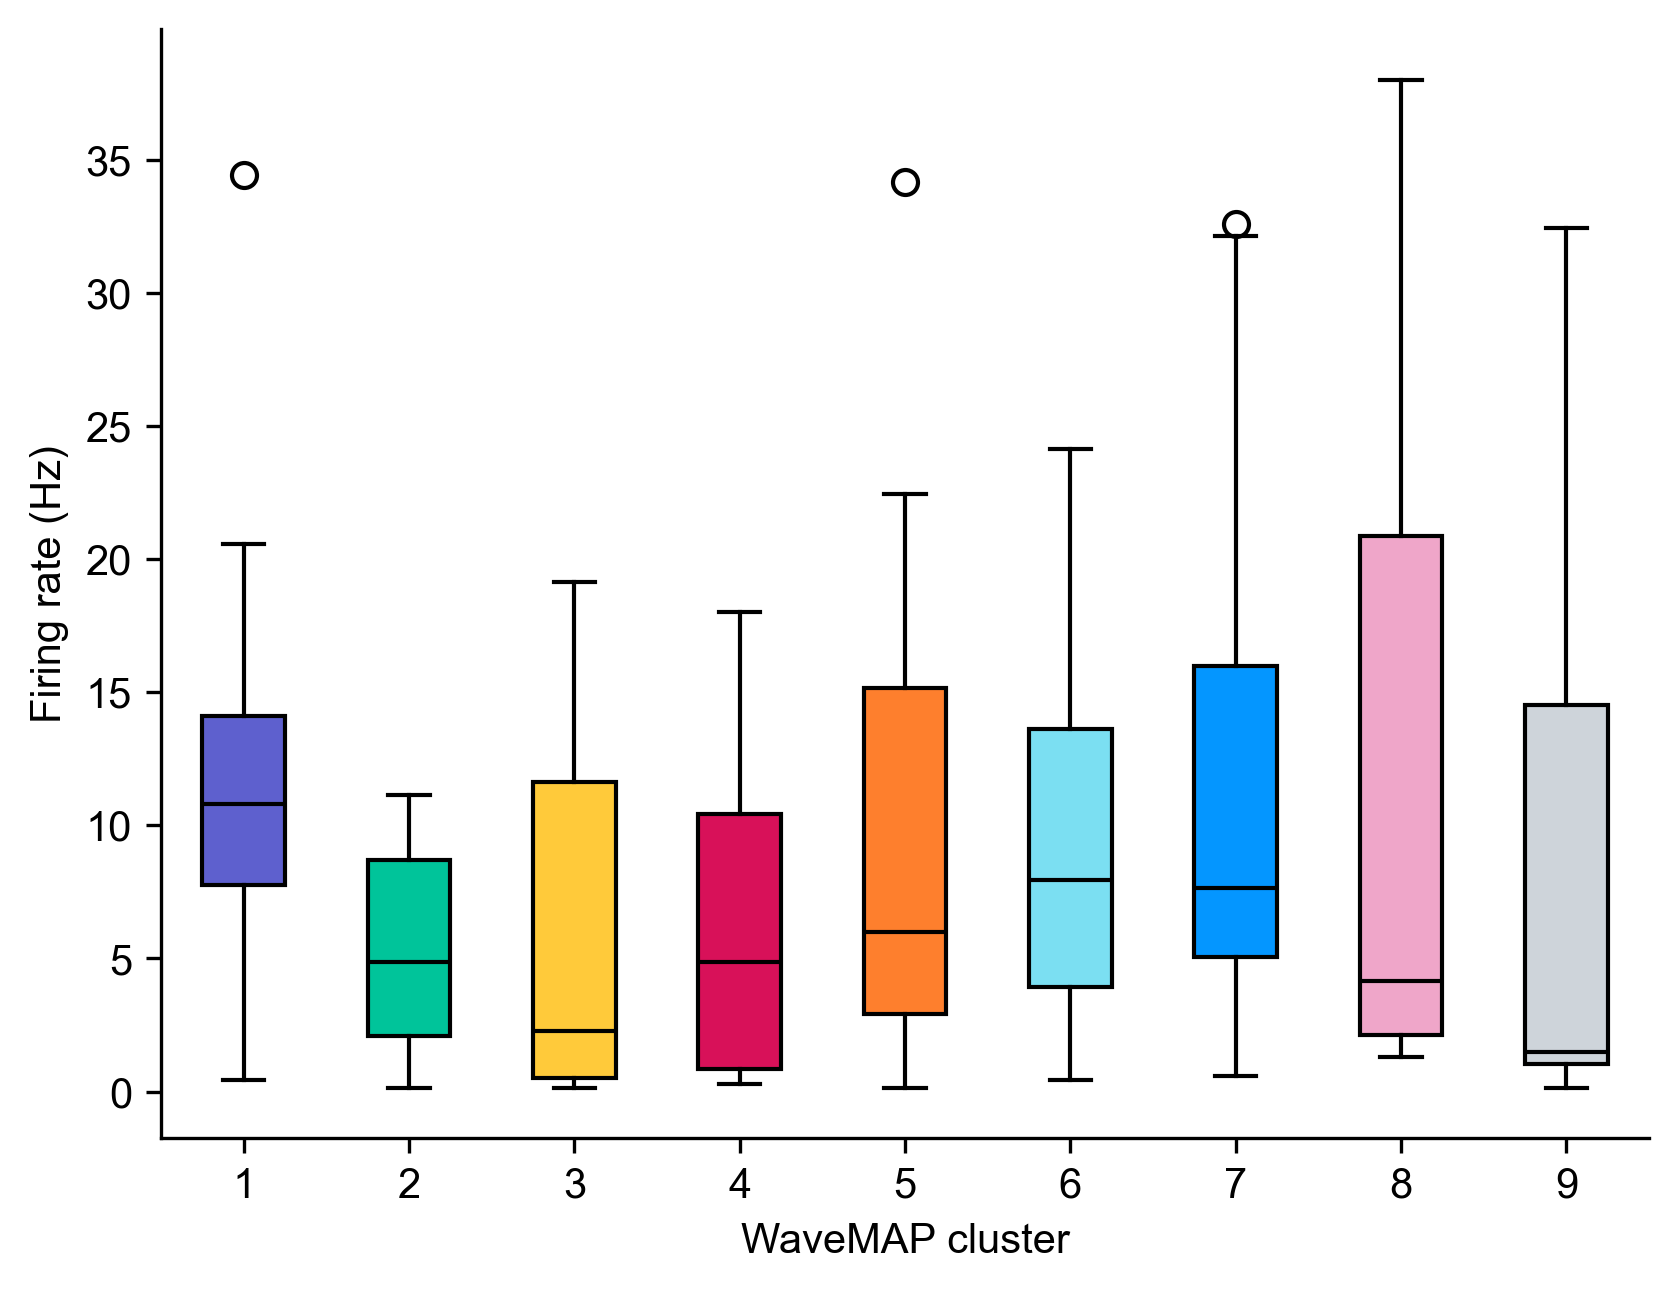

In [200]:
fig, ax = plt.subplots(dpi=300)

bplot = ax.boxplot(wavemap_cluster_FRs,
                   patch_artist=True,  # fill with color
                   medianprops={'color': 'k'})

# fill with colors
for patch, color in zip(bplot['boxes'], CUSTOM_PAL_SORT_3[:-1]):
    patch.set_facecolor(color)

plt.xlabel("WaveMAP cluster")
plt.ylabel("Firing rate (Hz)")
plt.show()

The mean firing rates for each cluster are all similar (within 10), but we have yet to see how these change if we select only units within a small distance from each other along the probe.

## Initial model

### FPP-GLM

We will see if we can use the filtered point process forward model to infer a spiking unit's contribution to the power spectrum. Under the FPP framework, the recorded signal can be described as

$$
Y^{\text{channel}}(t) = \sum_p X^{p}\circledast h^{p}(t)
$$

where $p$ is a process, $X$ is the point process, and $h$ is the filter. We hypothesize that the dominant contribution to the power spectrum is the spiking of a unit. Under this reasoning,

$$
Y^{\text{channel}}(t) \approx Y^{\text{unit}}=X^{\text{unit}}\circledast h^{\text{unit}}(t).
$$

Thus, the spectrum of the channel signal would be

$$
S_Y^{\text{channel}}(\omega)\approx S^{\text{unit}}_Y(\omega)=S^{\text{unit}}_X|\mathcal{H}(\omega)|^2.
$$

If we assume $X$ to be a homogeneous Poisson process with rate $\lambda_0$, its spectrum would also be $\lambda_0$. 

$$
S_Y^{\text{channel}}(\omega)\approx \lambda_0 |\mathcal{H}(\omega)|^2
$$

Theoretically, we can use a Gamma generalized linear model of the form $y=X\beta$ to estimate the firing rate parameter $\lambda_0$ where $y$ is the PSD of the channel signal, $X$ is the design matrix containing the filter (spike waveform), and $\beta$ is the rate parameter. To test this hypothesis, we can initially test if this method can decode the firing rate if the signal were only comprised of the individual spikes of a certain unit. The following extracts each observed spike from a unit on the channel.

In [ ]:
individual_spk_arr = np.zeros((channel_signals['ch163'].spike_times[296].size, fs*(time_window[1]-time_window[0])))

# this is a pretty inefficient way, it would just be easier to index the signal around each spike time
# but i already wrote this once i realized
for i,spk_time in enumerate(channel_signals['ch163'].spike_times[296]):
    individual_spk_arr[i,spk_time] = 1

    exact_spk_instance = np.convolve(individual_spk_arr[i], u296_instances['waveforms'][i])

    individual_spk_arr[i] = exact_spk_instance[20:-53]

exact_spks = np.sum(individual_spk_arr, axis=0)

c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Estimated Bias:               5.138
Theoretical $\lambda_0$:      5.286
Estimated $\lambda_0$:        5.138
Gamma Dispersion (phi):       0.283
Gamma Shape (k):              3.539


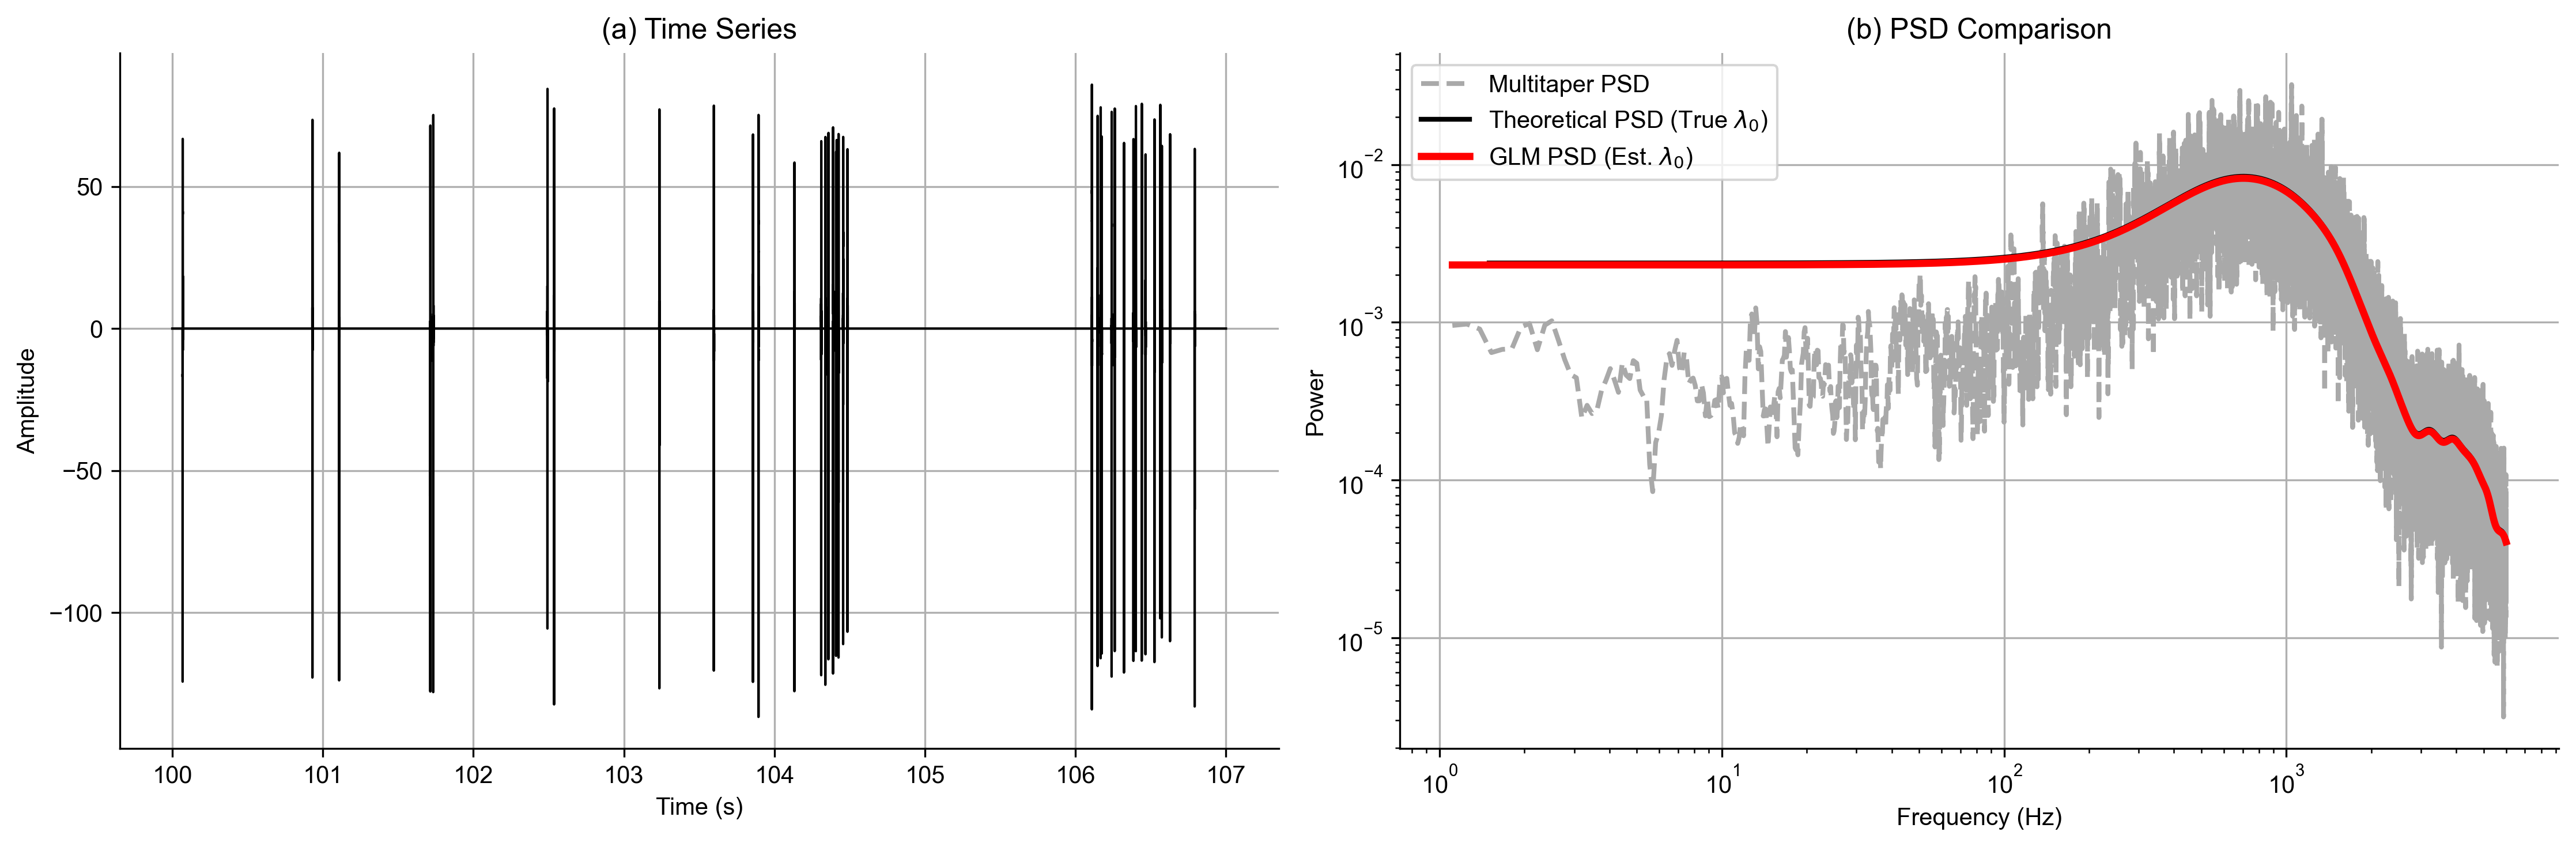

In [211]:
fppglm = FPPGLM(time_series=exact_spks,
                time_axis=channel_signals['ch163'].time_axis,
                fs=channel_signals['ch163'].fs, n_tapers=7)

obs_firing_rates = np.array([channel_signals['ch163'].firing_rates[296]])

fppglm.fit(filter_psd_list=[u296_filters['waveform_instance']['filter_psd']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(1,6000))

fppglm.plot_results()

As we can see, a FPP-GLM decoder can estimate the firing rate from a time-series signal containing only the observed spikes. However, when we actually attempt to decode the firing rate from an entire signal, we do not get accurate estimation.

c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Estimated Bias:               35.652
Theoretical $\lambda_0$:      5.286
Estimated $\lambda_0$:        35.652
Gamma Dispersion (phi):       1.142
Gamma Shape (k):              0.875


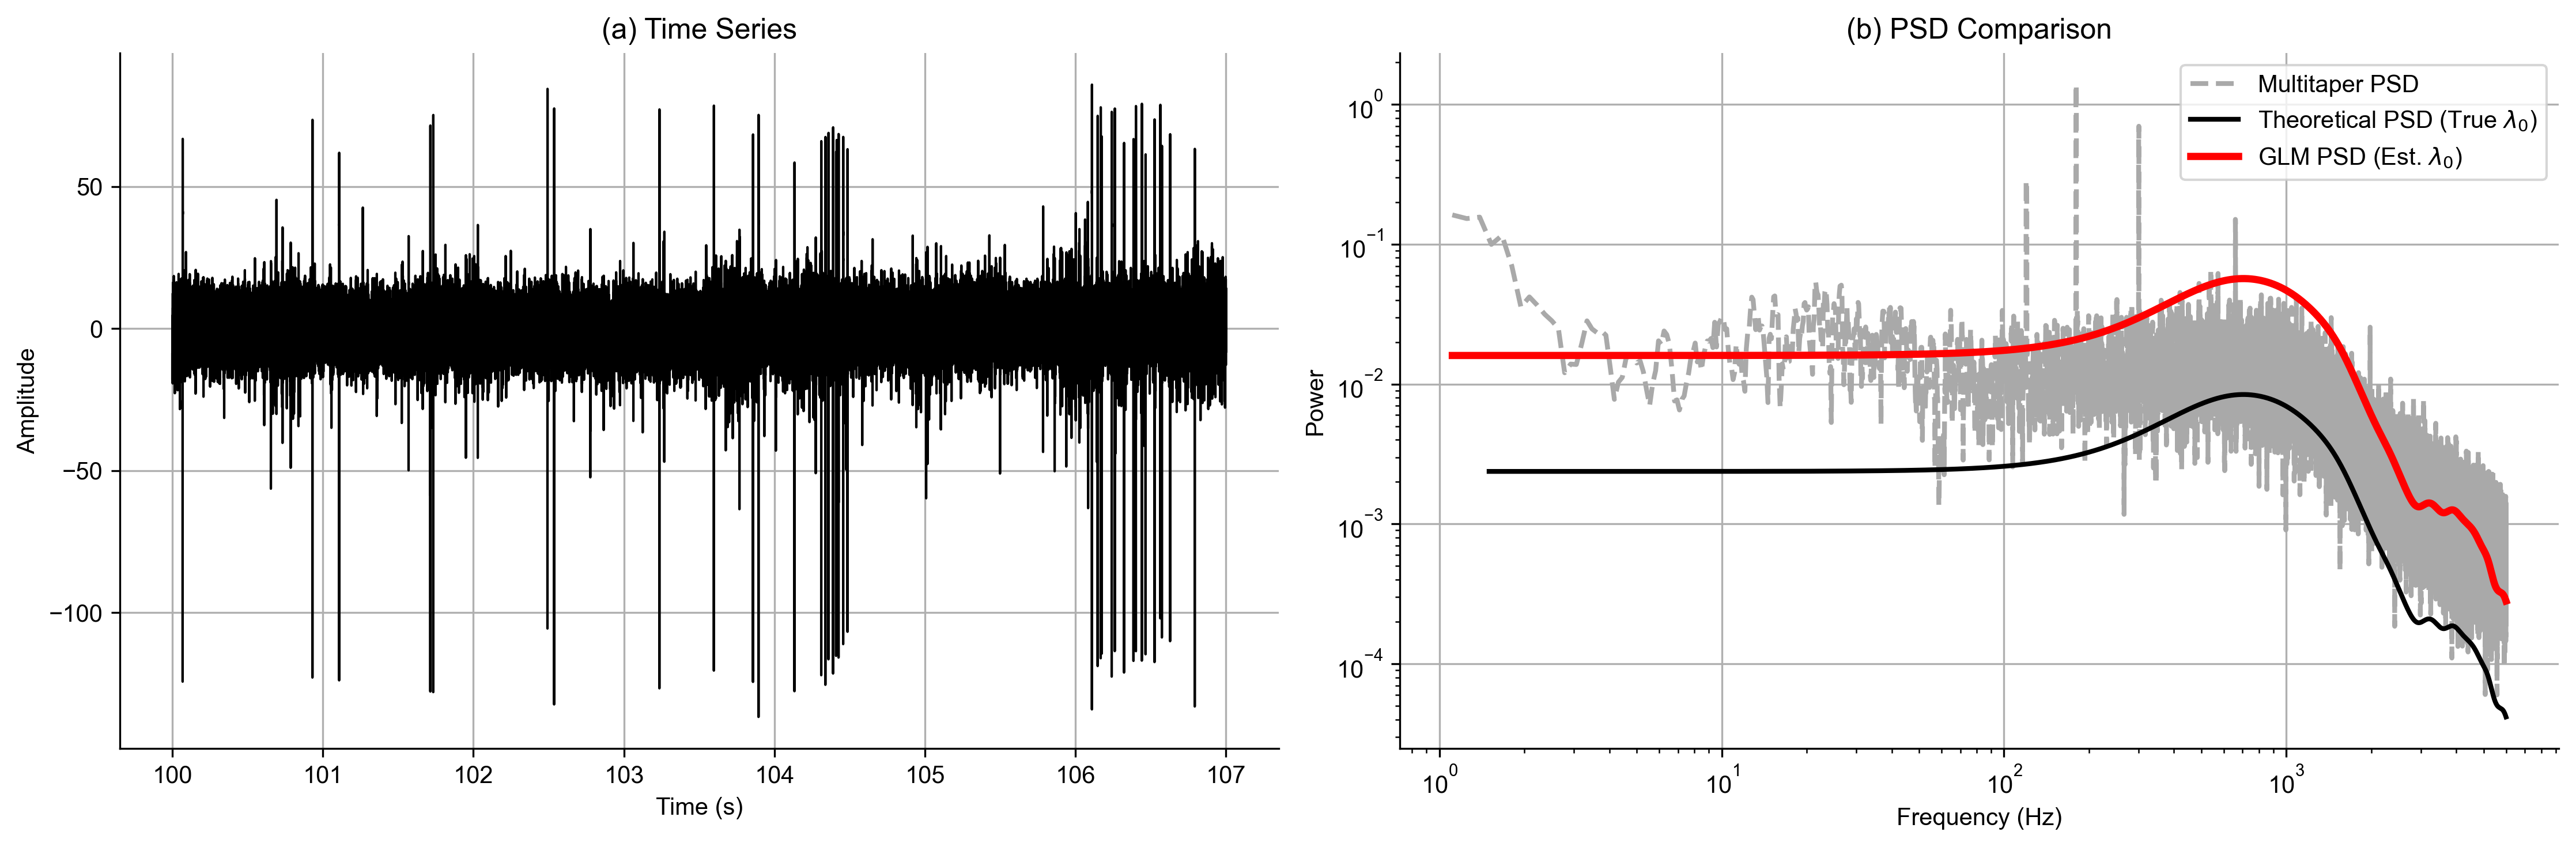

In [219]:
fppglm = FPPGLM(time_series=channel_signals['ch163'].time_series,
                time_axis=channel_signals['ch163'].time_axis,
                fs=channel_signals['ch163'].fs, n_tapers=7)

obs_firing_rates = np.array([channel_signals['ch163'].firing_rates[296]])

fppglm.fit(filter_psd_list=[u296_filters['waveform_instance']['filter_psd']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(1,6000))

fppglm.plot_results()

The GLM is overestimating $\lambda_0$ since it is primarily fitting the tail end of the spectrum as we are plotting in log space. We can also try restricting the frequency range to 2000 Hz.

Estimated Bias:               15.863
Theoretical $\lambda_0$:      5.286
Estimated $\lambda_0$:        15.863
Gamma Dispersion (phi):       9.736
Gamma Shape (k):              0.103


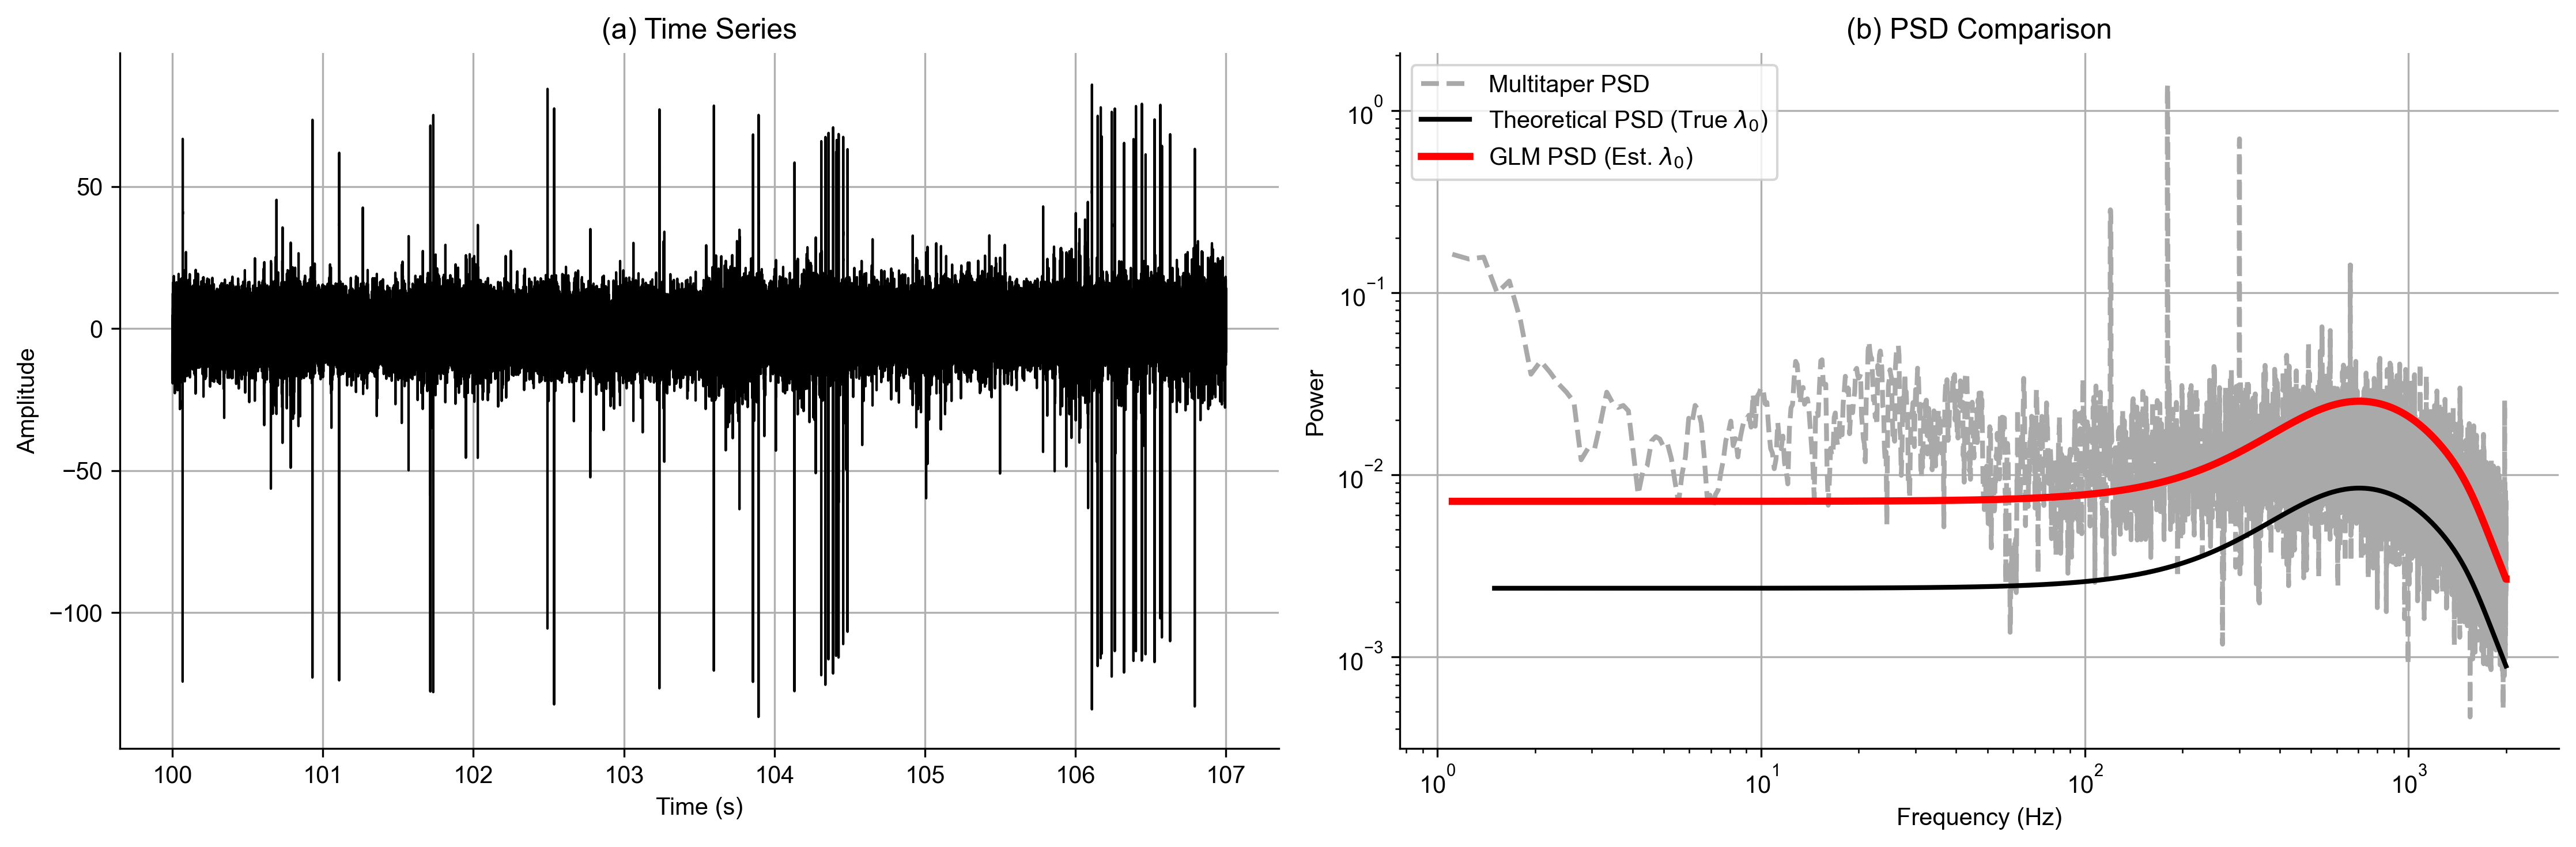

In [223]:
fppglm.fit(filter_psd_list=[u296_filters['waveform_instance']['filter_psd']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(1,2000))

fppglm.plot_results()

Even after constraining to the spiking band, we can see that the theoretical power spectrum (observed instance-averaged spike waveform PSD multiplied by the empirical $\lambda_0$) does not dominate any range of the spectrum.

### Probing individual unit contributions

We can look at a channel with multiple detected units and see if we can quantify their individual contributions to the power spectrum. To do this, we will calculate the theoretical power spectrum for each of the detected units on channel 208 with $\lambda_0 |\mathcal{H}(\omega)|^2$ where both values are observed. To recall:

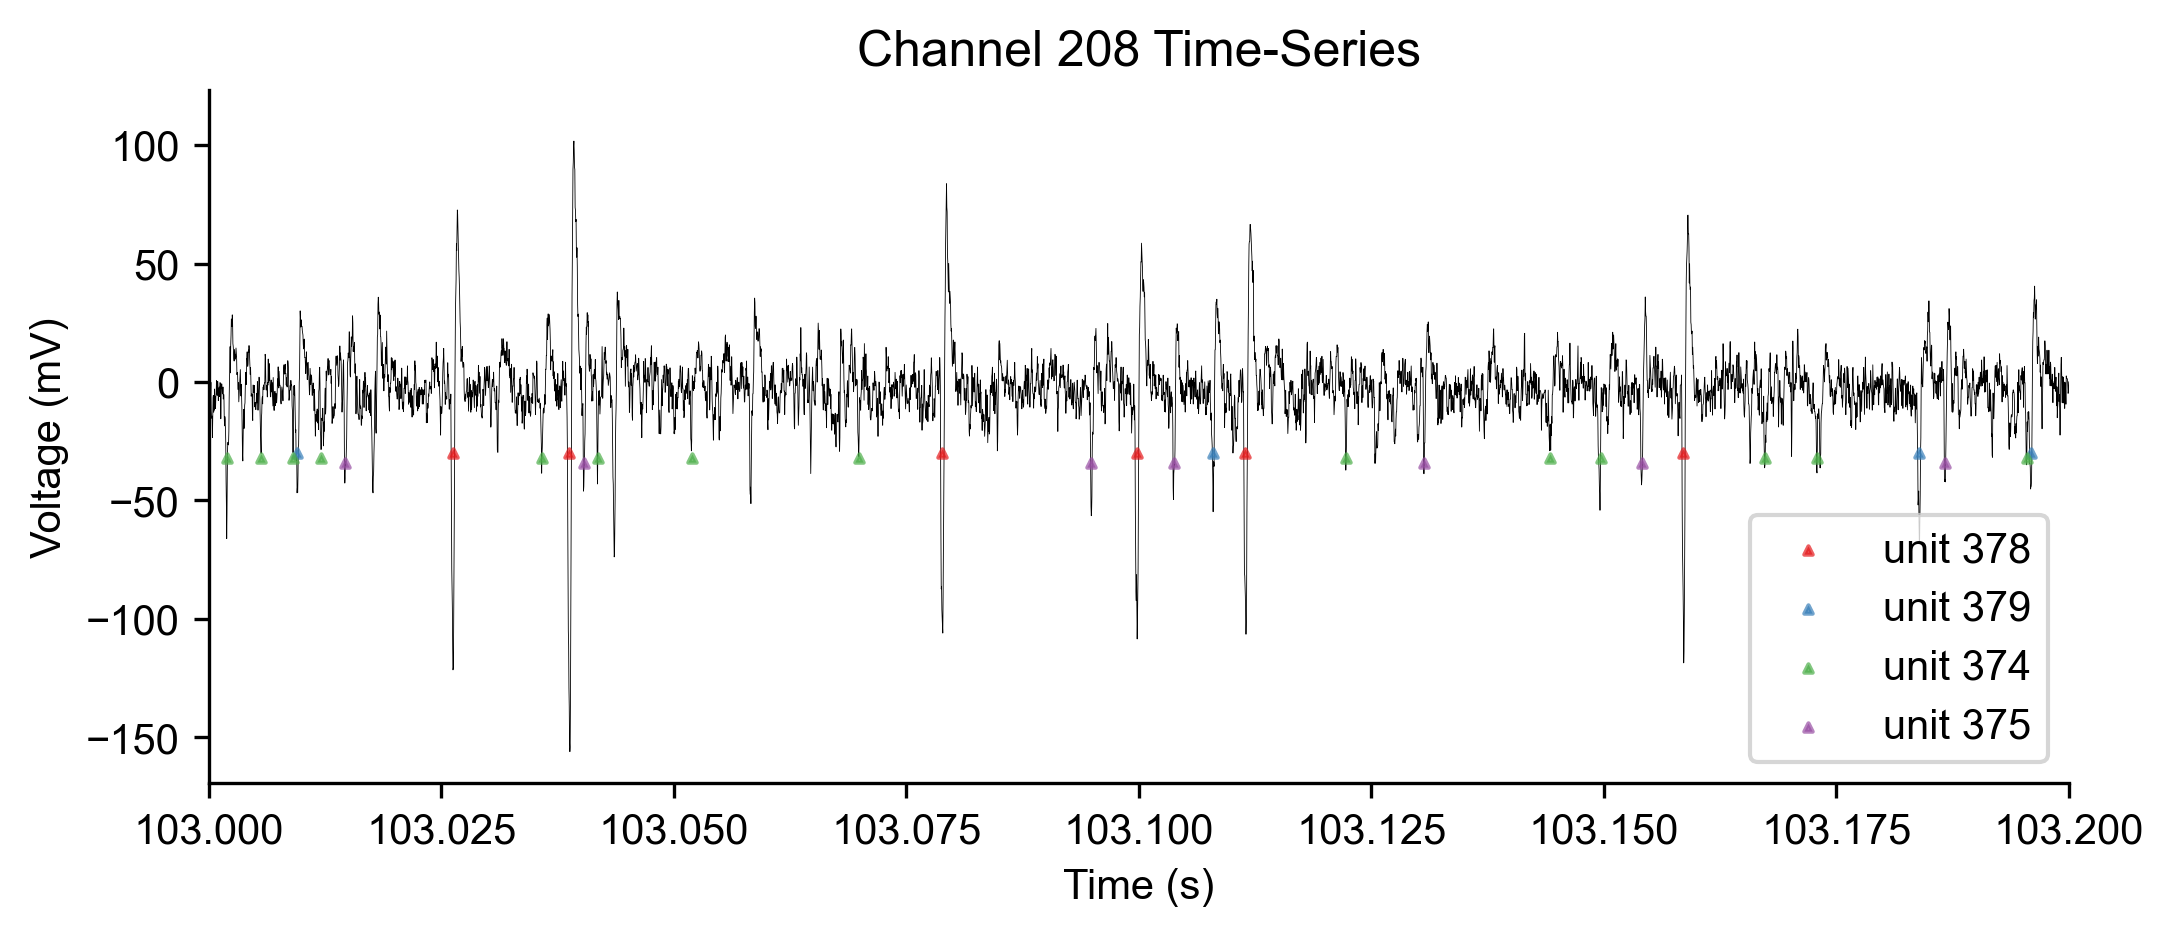

In [230]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375], xlim=(103,103.2))

In [225]:
u378_theor_PSD = u378_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch208'].firing_rates[378]
u379_theor_PSD = u379_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch208'].firing_rates[379]

u374_theor_PSD = u374_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch205'].firing_rates[374]
u375_theor_PSD = u375_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch205'].firing_rates[375]

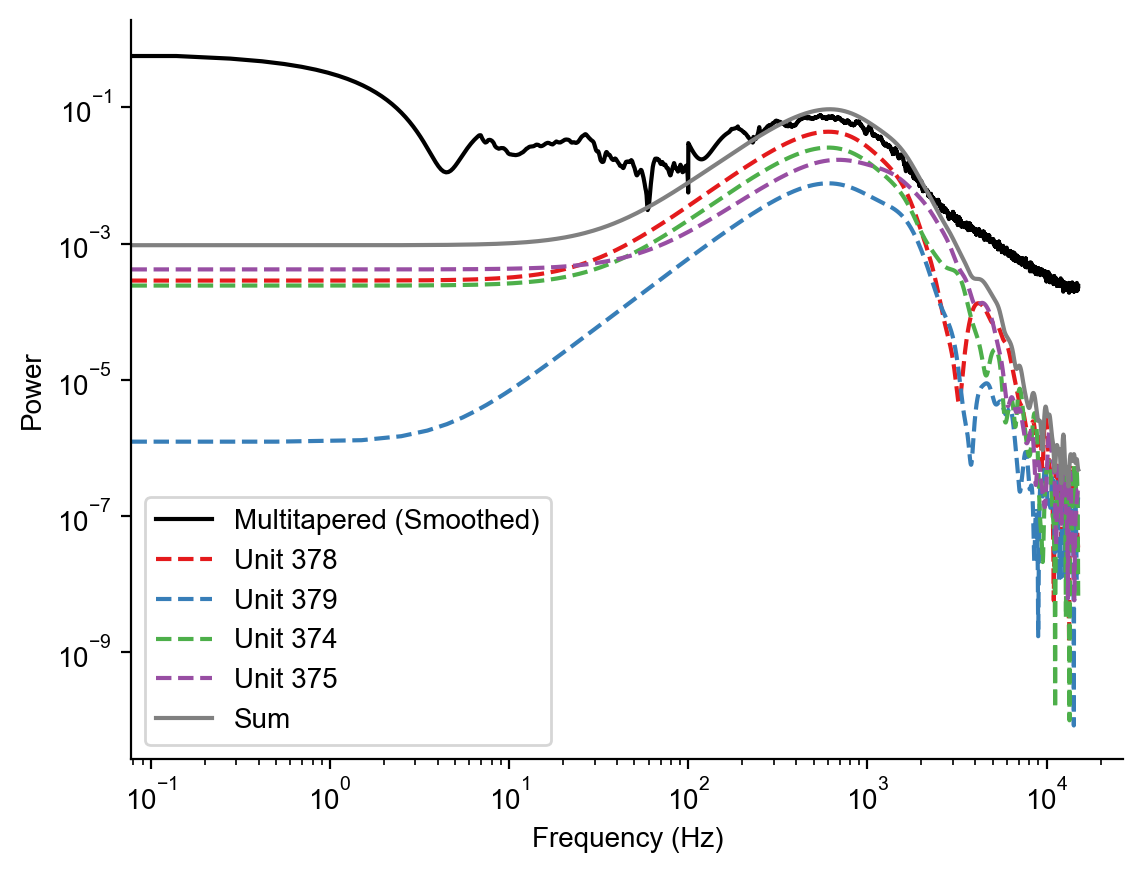

In [238]:
plt.figure(dpi=200)
plt.loglog(mt_freqs, ch208_PSD_smooth, color='k', label='Multitapered (Smoothed)')
plt.loglog(theor_freqs, u378_theor_PSD, color=cmap(0), linestyle='--', label='Unit 378')
plt.loglog(theor_freqs, u379_theor_PSD, color=cmap(1), linestyle='--', label='Unit 379')
plt.loglog(theor_freqs, u374_theor_PSD, color=cmap(2), linestyle='--', label='Unit 374')
plt.loglog(theor_freqs, u375_theor_PSD, color=cmap(3), linestyle='--', label='Unit 375')
plt.loglog(theor_freqs, u378_theor_PSD+u379_theor_PSD+u374_theor_PSD+u375_theor_PSD, color='gray', label='Sum')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()

The sum of the theoretical power spectra are able to match the power of the multitapered spectrum within the 300-1000 range which corresponds to the spiking band. However, with other channels, the summed spike spectra cannot explain the amplitude nor shape of the channel signal spectrum.

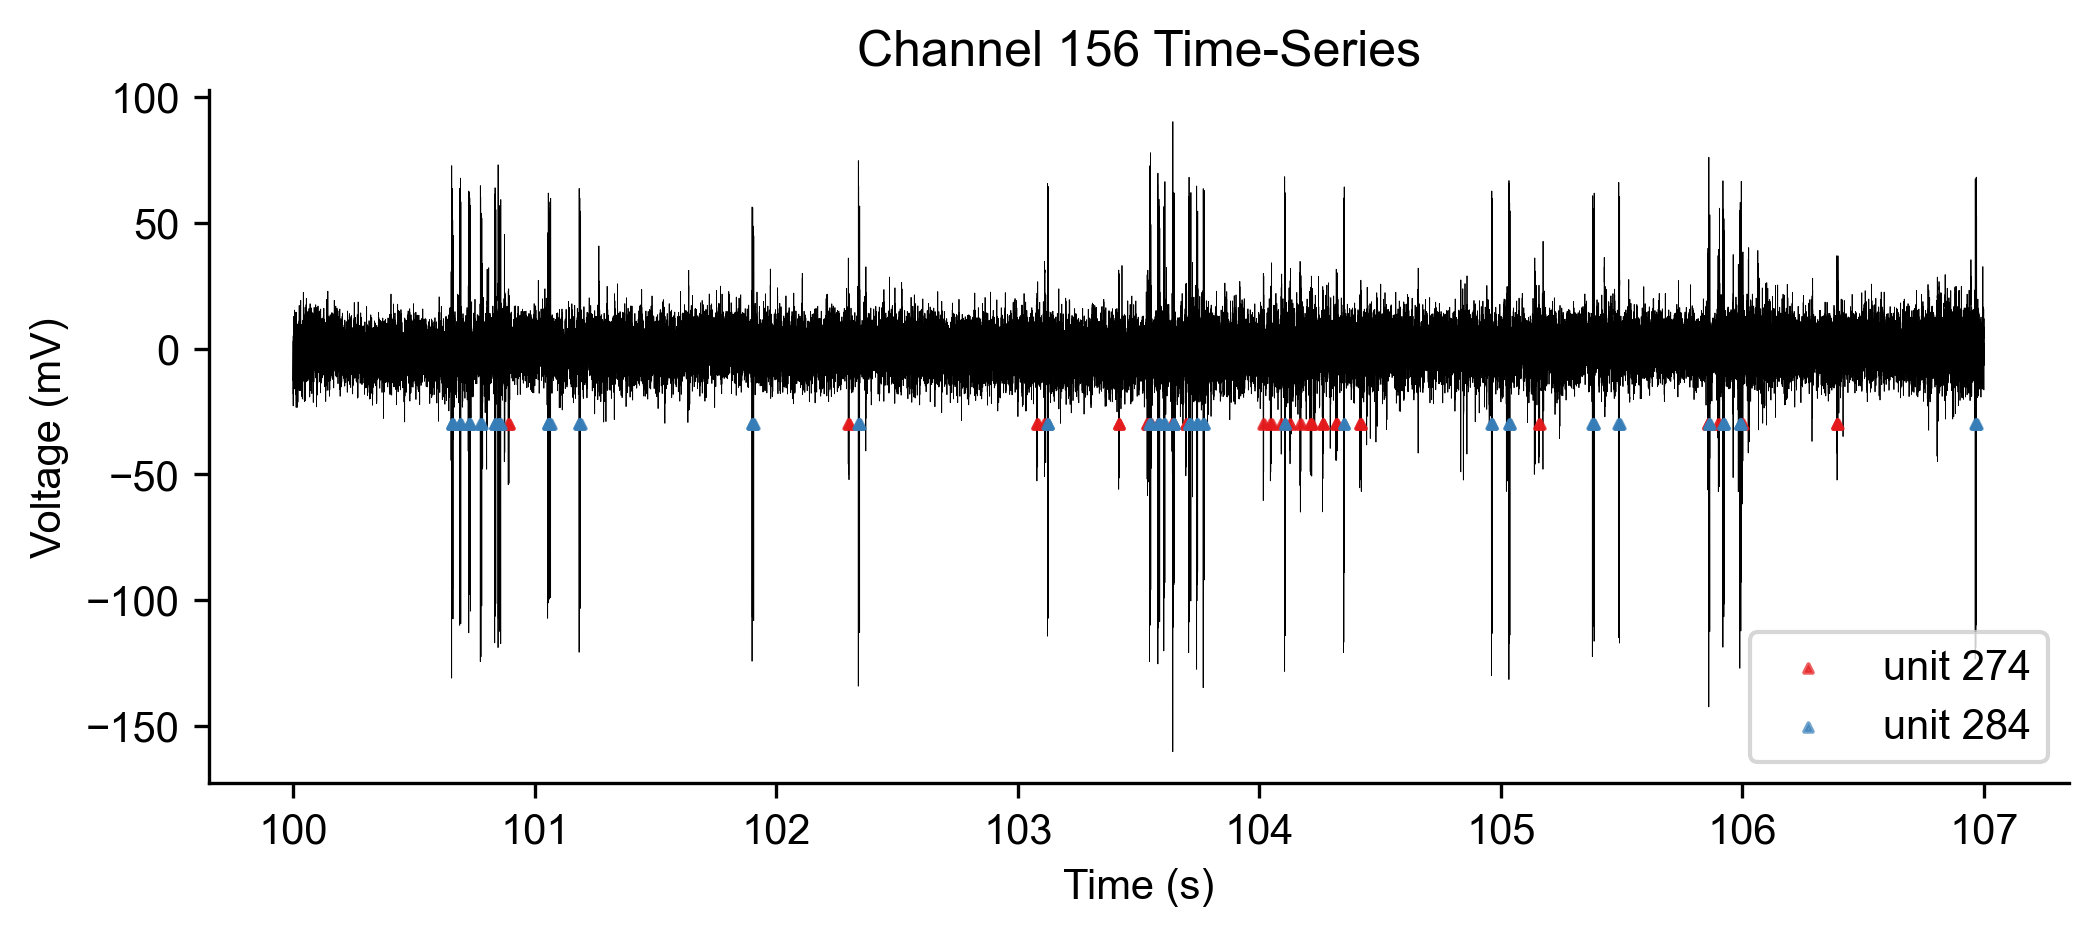

In [240]:
channel_signals['ch156'].plot_signal()

In [244]:
u274_instances,u274_filters,_ = channel_signals['ch156'].generate_unit_filters(selected_unit=274)
u284_instances,u284_filters,_ = channel_signals['ch156'].generate_unit_filters(selected_unit=284)

In [237]:
ch156_PSD,mt_freqs = fn.spectrafuncs.multitaper_psd(channel_signals['ch156'].time_series, fs, 7)
ch156_PSD_smooth = fn.spectrafuncs.spectrum_smooth(ch156_PSD, mt_freqs, 50, 1000, 100, 4)

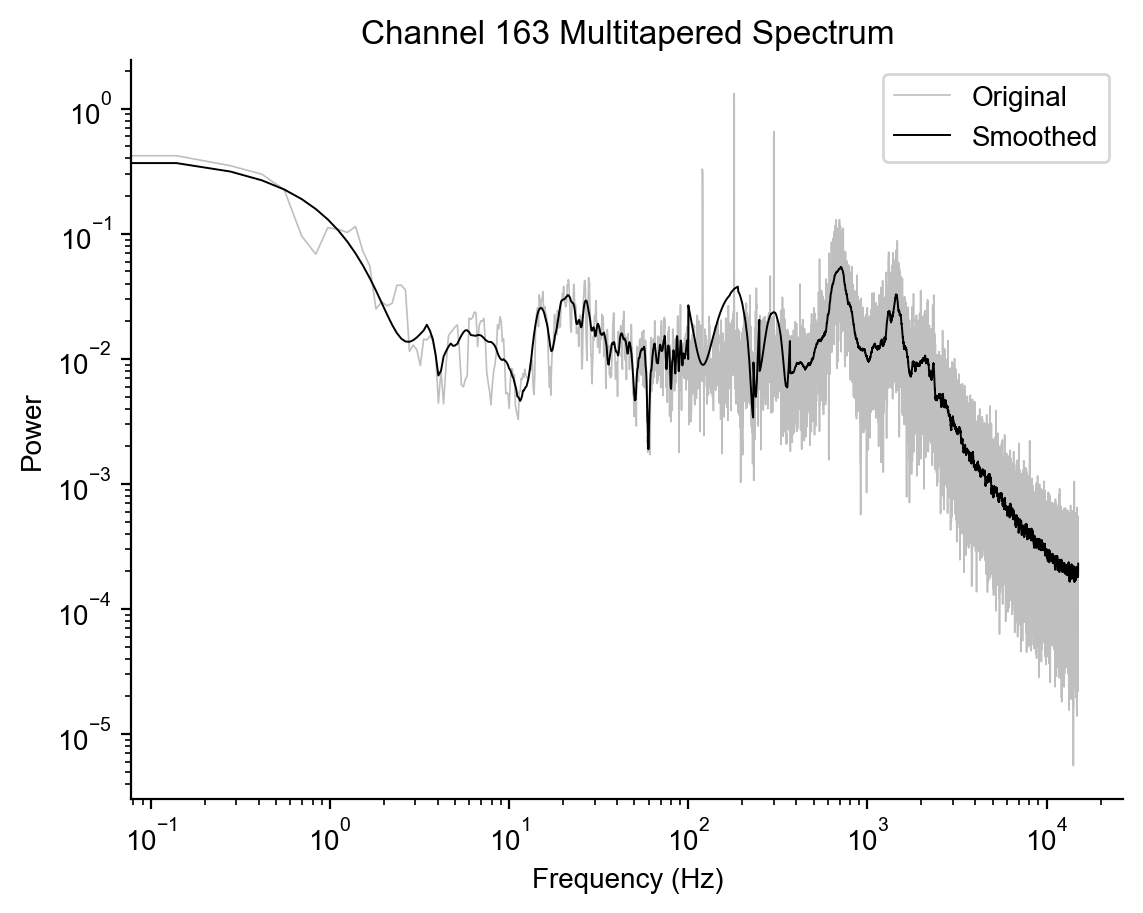

In [239]:
plt.figure(dpi=200)
plt.loglog(mt_freqs, ch156_PSD, alpha=0.5, color='gray', linewidth=0.6, label='Original')
plt.loglog(mt_freqs, ch156_PSD_smooth, color='k', linewidth=0.7, label='Smoothed')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Channel 163 Multitapered Spectrum")
plt.legend()
plt.show()

In [245]:
u274_theor_PSD = u274_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch156'].firing_rates[274]
u284_theor_PSD = u284_filters['waveform_instance']['filter_psd_iaw'] * channel_signals['ch156'].firing_rates[284]

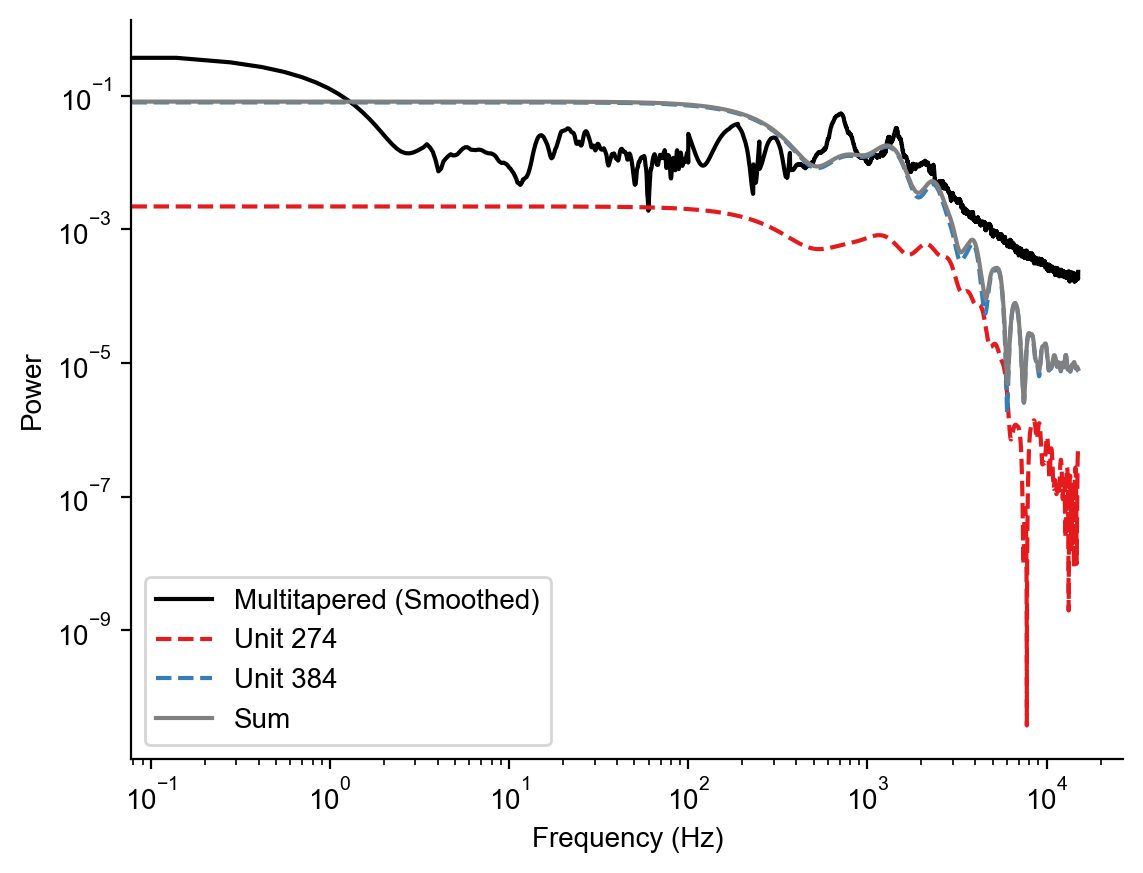

In [246]:
plt.figure(dpi=200)
plt.loglog(mt_freqs, ch156_PSD_smooth, color='k', label='Multitapered (Smoothed)')
plt.loglog(theor_freqs, u274_theor_PSD, color=cmap(0), linestyle='--', label='Unit 274')
plt.loglog(theor_freqs, u284_theor_PSD, color=cmap(1), linestyle='--', label='Unit 384')
plt.loglog(theor_freqs, u274_theor_PSD+u284_theor_PSD, color='gray', label='Sum')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.legend()

### FPP-GLM with multiple units

Here, we will see how the GLM estimates firing rates when there are multiple units. We will use channel 208.

c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Estimated Bias:               203.687
Theoretical $\lambda_0$:      17.000
Estimated $\lambda_0$:        203.687
Gamma Dispersion (phi):       1.129
Gamma Shape (k):              0.886


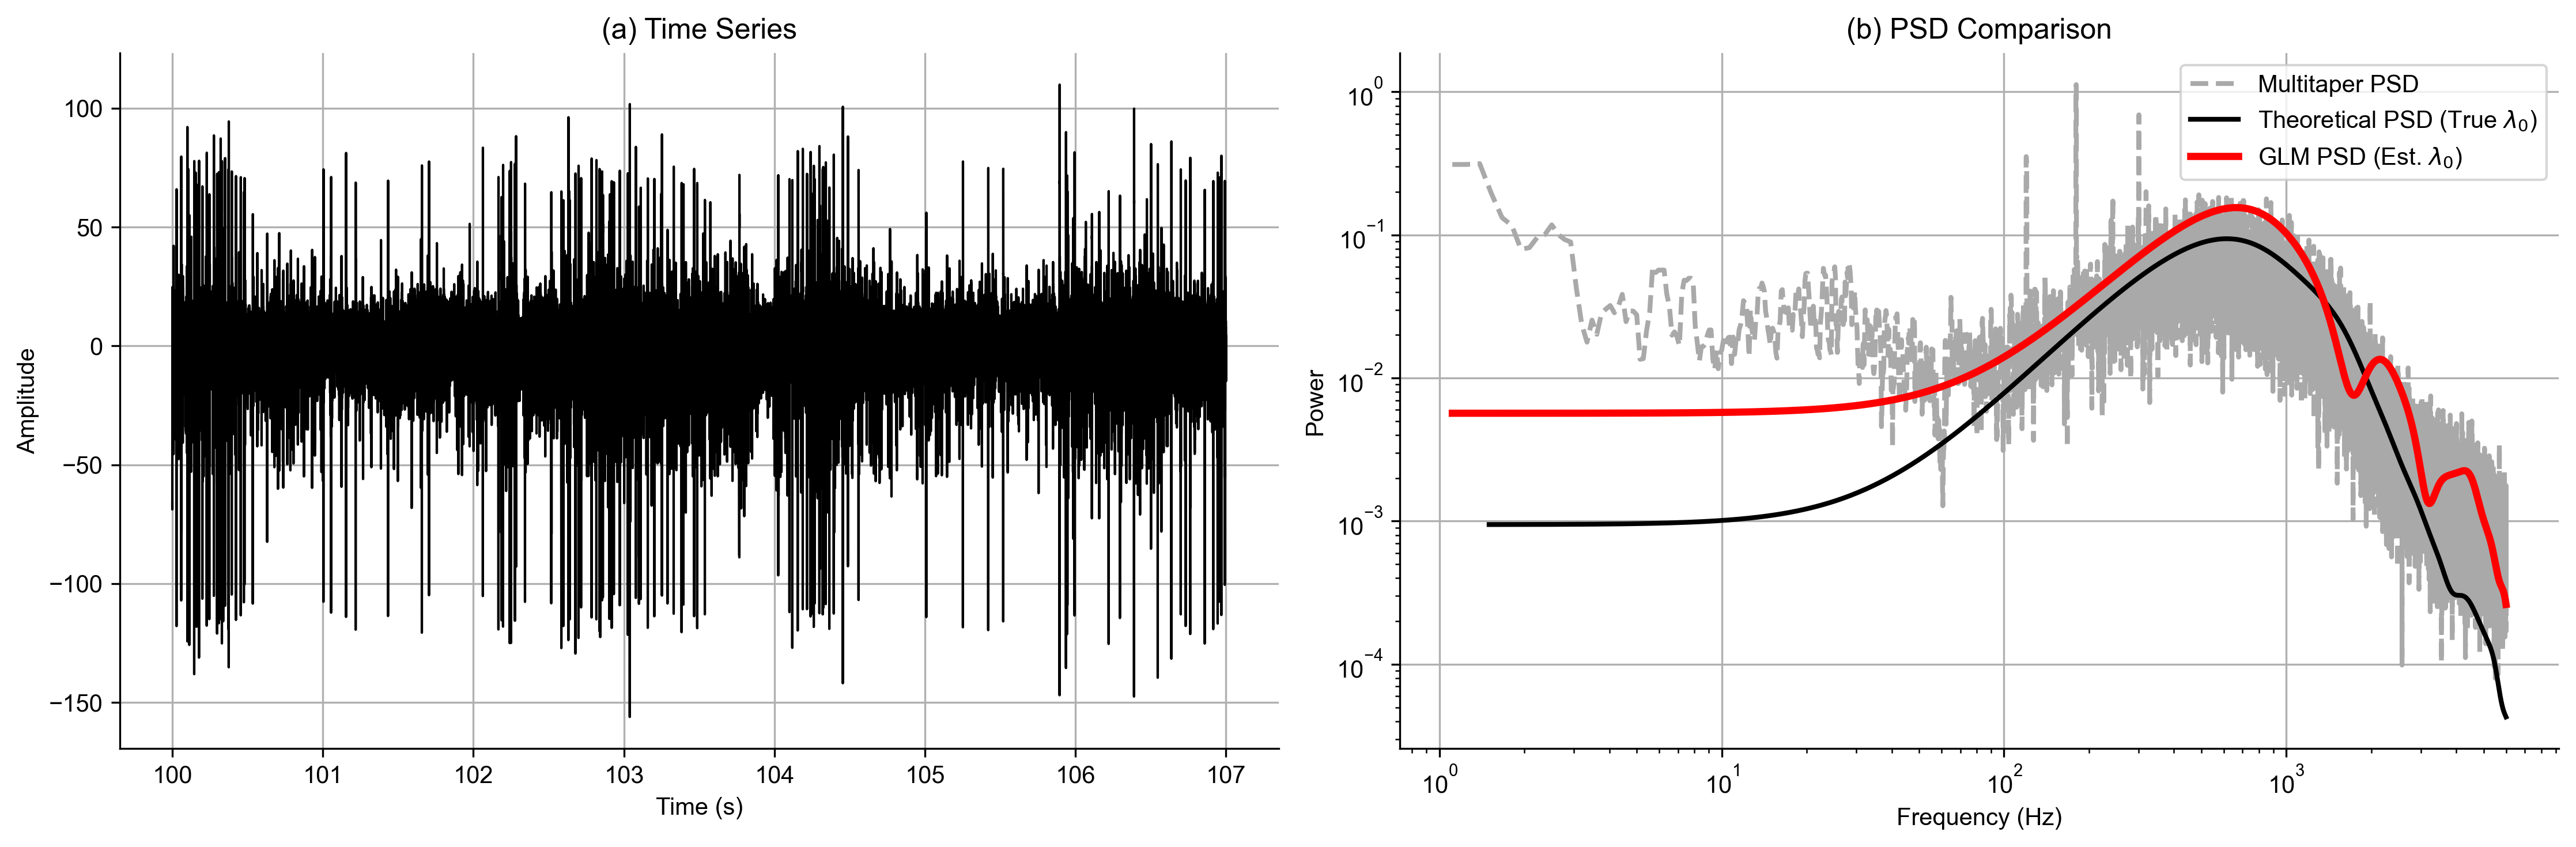

In [247]:
fppglm = FPPGLM(time_series=channel_signals['ch208'].time_series,
                time_axis=channel_signals['ch208'].time_axis,
                fs=channel_signals['ch208'].fs, n_tapers=7)

obs_firing_rates = np.array([channel_signals['ch208'].firing_rates[378],
                             channel_signals['ch208'].firing_rates[379],
                             channel_signals['ch205'].firing_rates[374],
                             channel_signals['ch205'].firing_rates[375]])

fppglm.fit(filter_psd_list=[u378_filters['waveform_instance']['filter_psd_iaw'],
                            u379_filters['waveform_instance']['filter_psd_iaw'],
                            u374_filters['waveform_instance']['filter_psd_iaw'],
                            u375_filters['waveform_instance']['filter_psd_iaw']],
           lambda_observed=obs_firing_rates,
           theoretical_frequencies=theor_freqs, bias=False,
           freq_range=(1,6000))

fppglm.plot_results()

In [249]:
print(f"Observed firing rates:  {obs_firing_rates}")
print(f"Estimated firing rates: {fppglm.lambda_estimated}")

Observed firing rates:  [17.         23.71428571 34.42857143 20.42857143]
Estimated firing rates: [  203.68718196 -1121.20933485  -221.05031074   188.78130874]


Although the theoretical and GLM-predicted PSD seem to match the multitapered spectrum well, the firing rate estimates were not accurate. This may be due to 1) the GLM fitting procedure allowing coefficients to be negative and 2) the similar waveform shapes resulting in multicollinearity. Perhaps non-negative least squares can be used to more accurately decode the firing rates.

## Future directions

- See if WaveMAP cluster (and just broad-spiking versus narrow-spiking) population-averaged firing rates are distinguishable by cluster at different locations along the probe
- Test non-negative least squares with the GLM
- Create more theoretical power spectra with the WaveMAP cluster waveforms
- Add distance (along the probe) as a parameter in the model